# Ⅱ. skin数据集

分析过程：

从data/skin/benchmarks/目录下随机抽取两个csv文件，然后使用pyod提供的接口使用KNN, LOF, PCA, LODA算法对抽样的数据训练得到离群点检测模型，计算和输出不同算法下模型的AUC、precision @ rank和ROC曲线。

然后，data/skin/benchmarks/目录下所有的csv文件执行离群点检测，将AUC、precision @ rank，检测模型执行时间，数据集的离群率记录在DataFrame对象中。

最后可视化记录检测评价的DataFrame对象的内容，对比不同算法的表现已经不同离群率下的数据集的表现。

初始化

In [12]:
import pandas as pd
import numpy as np
from pyod.models.knn import KNN
from pyod.models.pca import PCA
from pyod.models.loda import LODA
from pyod.models.lof import LOF
from pyod.utils.utility import standardizer
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from sklearn.metrics import roc_curve, auc
from pyod.utils.utility import precision_n_scores
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import time
import os

In [2]:
example = pd.read_csv("data/skin/benchmarks/skin_benchmark_0001.csv")
example.head()

,point.id,motherset,origin,original.label,diff.score,ground.truth,R,G,B
0,skin_point_117027,skin,binary,2,0.020405,nominal,-1.864336,-2.110524,-1.587289
1,skin_point_016927,skin,binary,1,0.000250,anomaly,0.384456,0.925785,1.747782
2,skin_point_240995,skin,binary,2,0.001285,nominal,-0.980882,-1.092860,-1.394351
3,skin_point_018861,skin,binary,1,0.000739,anomaly,-1.125447,-0.542320,0.383435
4,skin_point_087883,skin,binary,2,0.001053,nominal,-0.964819,-1.076177,-1.380570


从数据集中选取特征函数、获取训练集是否为离群点标签的函数

In [3]:
choosed_attrs = ["R","G","B"]
def str2bool(x):
    return 1 if x == "anomaly" else 0

def create_features(df):
    tmp = df.iloc[:,6:]
    return standardizer(tmp)
def get_label(df):
    y = df["ground.truth"]
    y = list(map(str2bool,y))
    return y

用于评价模型，输出并显示ROC曲线的函数

In [6]:
def show(title,clf_name, y, y_train_scores):
    evaluate_print(clf_name, y, y_train_scores)
    fpr, tpr, thresholds  =  roc_curve(y, y_train_scores) 
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5,5))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) 
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

## benchmark抽样分析

查看benchmark的元数据

In [8]:
meta = pd.read_csv('data/skin/meta_data/meta_skin.csv')
meta

,bench.id,benchnum,origin,mset,size,n.anom,n.norm,anomaly.rate.level,point.difficulty.level,clustering.algo,irrelevance.level,anomaly.rate,diff.mean,anom.diff.mean,norm.diff.mean,clusteredness.score,irrelevance.score,auc.ci.0.999,ap.ci.0.999
0,skin_benchmark_0001,1,binary,skin,6000,1217,4783,ar-0,pd-0,none,ir-0,0.202833,0.060019,0.084464,0.053800,1.077364,0.000000,0.525617,0.221824
1,skin_benchmark_0002,2,binary,skin,6000,1225,4775,ar-0,pd-0,none,ir-0,0.204167,0.058470,0.078569,0.053314,1.061695,0.000000,0.525605,0.223098
2,skin_benchmark_0003,3,binary,skin,6000,1245,4755,ar-0,pd-0,none,ir-0,0.207500,0.061087,0.087181,0.054254,1.043663,0.000000,0.525368,0.226587
3,skin_benchmark_0004,4,binary,skin,6000,1187,4813,ar-0,pd-0,none,ir-0,0.197833,0.056877,0.077470,0.051799,1.110271,0.000000,0.525846,0.216778
4,skin_benchmark_0005,5,binary,skin,6000,1241,4759,ar-0,pd-0,none,ir-0,0.206833,0.057646,0.079658,0.051906,1.011156,0.000000,0.525316,0.225858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,skin_benchmark_1736,1736,binary,skin,6000,600,5400,ar-6,pd-3,cluster,ir-3,0.100000,0.333377,0.493219,0.315617,1.172648,1.236871,0.536514,0.115960
1496,skin_benchmark_1737,1737,binary,skin,6000,600,5400,ar-6,pd-3,cluster,ir-3,0.100000,0.333343,0.489881,0.315950,1.208952,1.236117,0.536514,0.115960
1497,skin_benchmark_1738,1738,binary,skin,6000,600,5400,ar-6,pd-3,cluster,ir-3,0.100000,0.333341,0.489209,0.316022,1.094585,1.244969,0.536514,0.115960
1498,skin_benchmark_1739,1739,binary,skin,6000,600,5400,ar-6,pd-3,cluster,ir-3,0.100000,0.333339,0.495590,0.315311,1.275180,1.230456,0.536514,0.115960


选择skin_benchmark_0493、skin_benchmark_1267分析,使用PyOD工具包中的KNN, LOF, PCA, LODA对抽样个benchmark执行离群点检测，并可视化显示检测模型的评测结果。

In [69]:
examples = [
    "skin_benchmark_0493.csv",
      "skin_benchmark_1267.csv",
]
models = {
    "KNN": KNN(),
    "LOF": LOF(),
    "PCA": PCA(),
    "LODA": LODA(),
}
dfs = [pd.read_csv(os.path.join("data/skin/benchmarks",x)) for x in examples]

[0 0 0 ... 0 0 0]
KNN ROC:0.8115, precision @ rank n:0.0


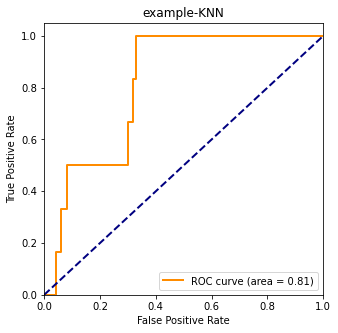

[0 0 0 ... 0 0 0]
LOF ROC:0.7922, precision @ rank n:0.0


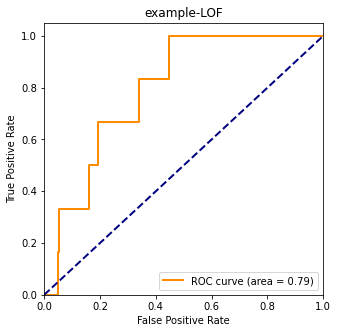

[0 0 0 ... 0 0 0]
PCA ROC:0.2389, precision @ rank n:0.0


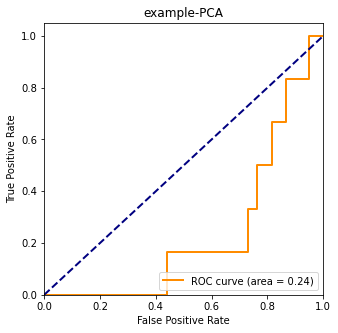

[0 0 0 ... 0 0 0]
LODA ROC:0.3019, precision @ rank n:0.0


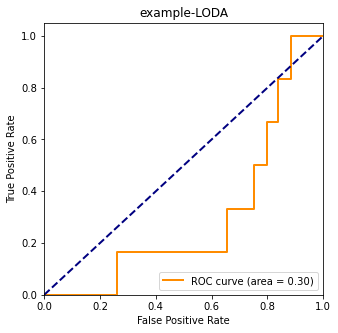

[0 0 0 ... 0 0 0]
KNN ROC:0.8591, precision @ rank n:0.0467


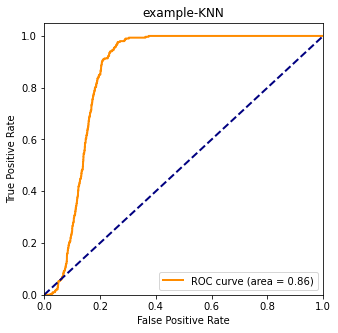

[0 0 0 ... 0 0 0]
LOF ROC:0.3424, precision @ rank n:0.0


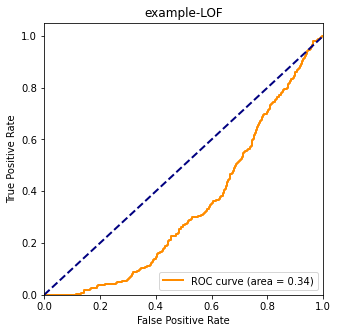

[1 0 0 ... 0 0 0]
PCA ROC:0.5498, precision @ rank n:0.0


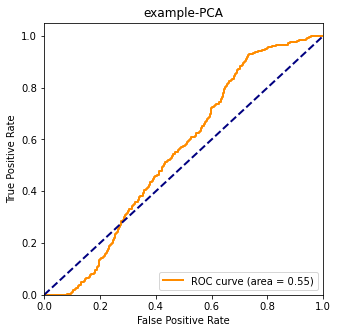

[0 0 0 ... 0 0 0]
LODA ROC:0.5675, precision @ rank n:0.04


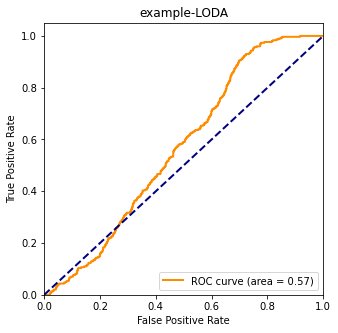

In [70]:
for df in dfs:
    x_train =  create_features(df)
    y_train =  get_label(df)
    c = y_train.count(1)/len(y_train)
    for k in models:
        clf_name = k
        clf = eval(k)(contamination = c)# 初始化检测器
        clf.fit(x_train)
        #得到训练数据的预测标签和离群值
        y_train_pred = clf.labels_  
        y_train_scores = clf.decision_scores_ 
        print(y_train_pred)
        #输出结果
        show("%s-%s"%("example",clf_name),clf_name,y_train,y_train_scores)

## 所有benchmark的分析

In [108]:
import os
import time
benchmark_path = "data/skin/benchmarks"
#记录结果的DataFrame
result = pd.DataFrame({
    "benchmark":[],
    "model":[],
    "AUC":[],
    "precision @ rank":[],
    "anomaly.rate":[],
    "time": []
})

for b in os.listdir(benchmark_path)[:]:
    p = os.path.join(benchmark_path,b)
    df = pd.read_csv(p)
    x_train = create_features(df)
    y_train = get_label(df)
    c = y_train.count(1)/len(y_train)
    c2 = c
    if c > 0.5: c =0.5
    for k in models:
        t0 = time.time()
        clf_name = k
        clf = eval(k)(contamination = c)# 初始化检测器
        clf.fit(x_train)
        #得到训练数据的预测标签和离群值
        y_train_pred = clf.labels_  
        y_train_scores = clf.decision_scores_ 
        #输出并写入DataFrame
        auc = round(roc_auc_score(y_train, y_train_scores), ndigits=4)
        prn = round(precision_n_scores(y_train, y_train_scores), ndigits=4)
        t1 = time.time()
        duration = round(t1 - t0, ndigits=4)    
        tmp_dict = { "benchmark":b,"model":k,"anomaly.rate":c2,"AUC":auc,"precision @ rank":prn,"time": duration}
        print(tmp_dict)
        new = pd.DataFrame(tmp_dict, index=[1])
        result = result.append(new,ignore_index=True)

{'benchmark': 'skin_benchmark_0001.csv', 'model': 'KNN', 'anomaly.rate': 0.20283333333333334, 'AUC': 0.7181, 'precision @ rank': 0.2432, 'time': 0.08}
{'benchmark': 'skin_benchmark_0001.csv', 'model': 'LOF', 'anomaly.rate': 0.20283333333333334, 'AUC': 0.4534, 'precision @ rank': 0.1027, 'time': 0.114}
{'benchmark': 'skin_benchmark_0001.csv', 'model': 'PCA', 'anomaly.rate': 0.20283333333333334, 'AUC': 0.4572, 'precision @ rank': 0.0288, 'time': 0.015}
{'benchmark': 'skin_benchmark_0001.csv', 'model': 'LODA', 'anomaly.rate': 0.20283333333333334, 'AUC': 0.4477, 'precision @ rank': 0.0265, 'time': 0.153}
{'benchmark': 'skin_benchmark_0002.csv', 'model': 'KNN', 'anomaly.rate': 0.20416666666666666, 'AUC': 0.7129, 'precision @ rank': 0.2327, 'time': 0.051}
{'benchmark': 'skin_benchmark_0002.csv', 'model': 'LOF', 'anomaly.rate': 0.20416666666666666, 'AUC': 0.4524, 'precision @ rank': 0.1412, 'time': 0.098}
{'benchmark': 'skin_benchmark_0002.csv', 'model': 'PCA', 'anomaly.rate': 0.2041666666666

{'benchmark': 'skin_benchmark_0015.csv', 'model': 'KNN', 'anomaly.rate': 0.205, 'AUC': 0.6667, 'precision @ rank': 0.2634, 'time': 0.1846}
{'benchmark': 'skin_benchmark_0015.csv', 'model': 'LOF', 'anomaly.rate': 0.205, 'AUC': 0.3926, 'precision @ rank': 0.1024, 'time': 0.318}
{'benchmark': 'skin_benchmark_0015.csv', 'model': 'PCA', 'anomaly.rate': 0.205, 'AUC': 0.4317, 'precision @ rank': 0.1081, 'time': 0.0271}
{'benchmark': 'skin_benchmark_0015.csv', 'model': 'LODA', 'anomaly.rate': 0.205, 'AUC': 0.4316, 'precision @ rank': 0.0984, 'time': 0.115}
{'benchmark': 'skin_benchmark_0016.csv', 'model': 'KNN', 'anomaly.rate': 0.2035, 'AUC': 0.6278, 'precision @ rank': 0.2613, 'time': 0.9891}
{'benchmark': 'skin_benchmark_0016.csv', 'model': 'LOF', 'anomaly.rate': 0.2035, 'AUC': 0.5611, 'precision @ rank': 0.1957, 'time': 1.3049}
{'benchmark': 'skin_benchmark_0016.csv', 'model': 'PCA', 'anomaly.rate': 0.2035, 'AUC': 0.4478, 'precision @ rank': 0.1269, 'time': 0.023}
{'benchmark': 'skin_benchm

{'benchmark': 'skin_benchmark_0029.csv', 'model': 'KNN', 'anomaly.rate': 0.205, 'AUC': 0.6607, 'precision @ rank': 0.2325, 'time': 0.08}
{'benchmark': 'skin_benchmark_0029.csv', 'model': 'LOF', 'anomaly.rate': 0.205, 'AUC': 0.4515, 'precision @ rank': 0.1821, 'time': 0.133}
{'benchmark': 'skin_benchmark_0029.csv', 'model': 'PCA', 'anomaly.rate': 0.205, 'AUC': 0.637, 'precision @ rank': 0.3837, 'time': 0.025}
{'benchmark': 'skin_benchmark_0029.csv', 'model': 'LODA', 'anomaly.rate': 0.205, 'AUC': 0.6652, 'precision @ rank': 0.3049, 'time': 0.125}
{'benchmark': 'skin_benchmark_0030.csv', 'model': 'KNN', 'anomaly.rate': 0.21216666666666667, 'AUC': 0.7294, 'precision @ rank': 0.293, 'time': 0.072}
{'benchmark': 'skin_benchmark_0030.csv', 'model': 'LOF', 'anomaly.rate': 0.21216666666666667, 'AUC': 0.4453, 'precision @ rank': 0.1155, 'time': 0.122}
{'benchmark': 'skin_benchmark_0030.csv', 'model': 'PCA', 'anomaly.rate': 0.21216666666666667, 'AUC': 0.7254, 'precision @ rank': 0.2954, 'time': 0

{'benchmark': 'skin_benchmark_0043.csv', 'model': 'PCA', 'anomaly.rate': 0.21233333333333335, 'AUC': 0.4337, 'precision @ rank': 0.0386, 'time': 0.013}
{'benchmark': 'skin_benchmark_0043.csv', 'model': 'LODA', 'anomaly.rate': 0.21233333333333335, 'AUC': 0.4224, 'precision @ rank': 0.0501, 'time': 0.13}
{'benchmark': 'skin_benchmark_0044.csv', 'model': 'KNN', 'anomaly.rate': 0.20266666666666666, 'AUC': 0.7304, 'precision @ rank': 0.2617, 'time': 0.052}
{'benchmark': 'skin_benchmark_0044.csv', 'model': 'LOF', 'anomaly.rate': 0.20266666666666666, 'AUC': 0.4187, 'precision @ rank': 0.1151, 'time': 0.108}
{'benchmark': 'skin_benchmark_0044.csv', 'model': 'PCA', 'anomaly.rate': 0.20266666666666666, 'AUC': 0.4576, 'precision @ rank': 0.0255, 'time': 0.013}
{'benchmark': 'skin_benchmark_0044.csv', 'model': 'LODA', 'anomaly.rate': 0.20266666666666666, 'AUC': 0.4241, 'precision @ rank': 0.044, 'time': 0.124}
{'benchmark': 'skin_benchmark_0045.csv', 'model': 'KNN', 'anomaly.rate': 0.2151666666666

{'benchmark': 'skin_benchmark_0058.csv', 'model': 'KNN', 'anomaly.rate': 0.20333333333333334, 'AUC': 0.6226, 'precision @ rank': 0.2475, 'time': 0.8866}
{'benchmark': 'skin_benchmark_0058.csv', 'model': 'LOF', 'anomaly.rate': 0.20333333333333334, 'AUC': 0.5543, 'precision @ rank': 0.2008, 'time': 0.9461}
{'benchmark': 'skin_benchmark_0058.csv', 'model': 'PCA', 'anomaly.rate': 0.20333333333333334, 'AUC': 0.4326, 'precision @ rank': 0.1098, 'time': 0.02}
{'benchmark': 'skin_benchmark_0058.csv', 'model': 'LODA', 'anomaly.rate': 0.20333333333333334, 'AUC': 0.4824, 'precision @ rank': 0.1549, 'time': 0.116}
{'benchmark': 'skin_benchmark_0059.csv', 'model': 'KNN', 'anomaly.rate': 0.21, 'AUC': 0.6143, 'precision @ rank': 0.2563, 'time': 0.7221}
{'benchmark': 'skin_benchmark_0059.csv', 'model': 'LOF', 'anomaly.rate': 0.21, 'AUC': 0.5635, 'precision @ rank': 0.2143, 'time': 0.9679}
{'benchmark': 'skin_benchmark_0059.csv', 'model': 'PCA', 'anomaly.rate': 0.21, 'AUC': 0.4348, 'precision @ rank': 

{'benchmark': 'skin_benchmark_0072.csv', 'model': 'LOF', 'anomaly.rate': 0.21183333333333335, 'AUC': 0.417, 'precision @ rank': 0.1172, 'time': 0.221}
{'benchmark': 'skin_benchmark_0072.csv', 'model': 'PCA', 'anomaly.rate': 0.21183333333333335, 'AUC': 0.4318, 'precision @ rank': 0.0999, 'time': 0.019}
{'benchmark': 'skin_benchmark_0072.csv', 'model': 'LODA', 'anomaly.rate': 0.21183333333333335, 'AUC': 0.422, 'precision @ rank': 0.0858, 'time': 0.1416}
{'benchmark': 'skin_benchmark_0073.csv', 'model': 'KNN', 'anomaly.rate': 0.21666666666666667, 'AUC': 0.6454, 'precision @ rank': 0.2615, 'time': 0.1985}
{'benchmark': 'skin_benchmark_0073.csv', 'model': 'LOF', 'anomaly.rate': 0.21666666666666667, 'AUC': 0.4095, 'precision @ rank': 0.1308, 'time': 0.246}
{'benchmark': 'skin_benchmark_0073.csv', 'model': 'PCA', 'anomaly.rate': 0.21666666666666667, 'AUC': 0.4353, 'precision @ rank': 0.1115, 'time': 0.015}
{'benchmark': 'skin_benchmark_0073.csv', 'model': 'LODA', 'anomaly.rate': 0.21666666666

{'benchmark': 'skin_benchmark_0086.csv', 'model': 'LODA', 'anomaly.rate': 0.2055, 'AUC': 0.7456, 'precision @ rank': 0.3204, 'time': 0.122}
{'benchmark': 'skin_benchmark_0087.csv', 'model': 'KNN', 'anomaly.rate': 0.20533333333333334, 'AUC': 0.6325, 'precision @ rank': 0.2305, 'time': 0.106}
{'benchmark': 'skin_benchmark_0087.csv', 'model': 'LOF', 'anomaly.rate': 0.20533333333333334, 'AUC': 0.4434, 'precision @ rank': 0.1631, 'time': 0.126}
{'benchmark': 'skin_benchmark_0087.csv', 'model': 'PCA', 'anomaly.rate': 0.20533333333333334, 'AUC': 0.6109, 'precision @ rank': 0.4083, 'time': 0.025}
{'benchmark': 'skin_benchmark_0087.csv', 'model': 'LODA', 'anomaly.rate': 0.20533333333333334, 'AUC': 0.6917, 'precision @ rank': 0.3726, 'time': 0.1529}
{'benchmark': 'skin_benchmark_0088.csv', 'model': 'KNN', 'anomaly.rate': 0.21, 'AUC': 0.6676, 'precision @ rank': 0.296, 'time': 0.083}
{'benchmark': 'skin_benchmark_0088.csv', 'model': 'LOF', 'anomaly.rate': 0.21, 'AUC': 0.4584, 'precision @ rank': 

{'benchmark': 'skin_benchmark_0101.csv', 'model': 'KNN', 'anomaly.rate': 0.20716666666666667, 'AUC': 0.7189, 'precision @ rank': 0.2486, 'time': 0.053}
{'benchmark': 'skin_benchmark_0101.csv', 'model': 'LOF', 'anomaly.rate': 0.20716666666666667, 'AUC': 0.4173, 'precision @ rank': 0.1183, 'time': 0.073}
{'benchmark': 'skin_benchmark_0101.csv', 'model': 'PCA', 'anomaly.rate': 0.20716666666666667, 'AUC': 0.4443, 'precision @ rank': 0.0426, 'time': 0.01}
{'benchmark': 'skin_benchmark_0101.csv', 'model': 'LODA', 'anomaly.rate': 0.20716666666666667, 'AUC': 0.4079, 'precision @ rank': 0.0346, 'time': 0.105}
{'benchmark': 'skin_benchmark_0102.csv', 'model': 'KNN', 'anomaly.rate': 0.19766666666666666, 'AUC': 0.7262, 'precision @ rank': 0.2403, 'time': 0.056}
{'benchmark': 'skin_benchmark_0102.csv', 'model': 'LOF', 'anomaly.rate': 0.19766666666666666, 'AUC': 0.4276, 'precision @ rank': 0.1206, 'time': 0.083}
{'benchmark': 'skin_benchmark_0102.csv', 'model': 'PCA', 'anomaly.rate': 0.1976666666666

{'benchmark': 'skin_benchmark_0115.csv', 'model': 'LOF', 'anomaly.rate': 0.20933333333333334, 'AUC': 0.3913, 'precision @ rank': 0.0995, 'time': 0.288}
{'benchmark': 'skin_benchmark_0115.csv', 'model': 'PCA', 'anomaly.rate': 0.20933333333333334, 'AUC': 0.4479, 'precision @ rank': 0.0908, 'time': 0.018}
{'benchmark': 'skin_benchmark_0115.csv', 'model': 'LODA', 'anomaly.rate': 0.20933333333333334, 'AUC': 0.5106, 'precision @ rank': 0.1935, 'time': 0.098}
{'benchmark': 'skin_benchmark_0116.csv', 'model': 'KNN', 'anomaly.rate': 0.20266666666666666, 'AUC': 0.6087, 'precision @ rank': 0.2286, 'time': 0.7111}
{'benchmark': 'skin_benchmark_0116.csv', 'model': 'LOF', 'anomaly.rate': 0.20266666666666666, 'AUC': 0.5701, 'precision @ rank': 0.1941, 'time': 1.1071}
{'benchmark': 'skin_benchmark_0116.csv', 'model': 'PCA', 'anomaly.rate': 0.20266666666666666, 'AUC': 0.4409, 'precision @ rank': 0.1127, 'time': 0.022}
{'benchmark': 'skin_benchmark_0116.csv', 'model': 'LODA', 'anomaly.rate': 0.202666666

{'benchmark': 'skin_benchmark_0129.csv', 'model': 'LODA', 'anomaly.rate': 0.2035, 'AUC': 0.4224, 'precision @ rank': 0.1032, 'time': 0.147}
{'benchmark': 'skin_benchmark_0130.csv', 'model': 'KNN', 'anomaly.rate': 0.21116666666666667, 'AUC': 0.5135, 'precision @ rank': 0.0616, 'time': 0.065}
{'benchmark': 'skin_benchmark_0130.csv', 'model': 'LOF', 'anomaly.rate': 0.21116666666666667, 'AUC': 0.3565, 'precision @ rank': 0.0521, 'time': 0.126}
{'benchmark': 'skin_benchmark_0130.csv', 'model': 'PCA', 'anomaly.rate': 0.21116666666666667, 'AUC': 0.3322, 'precision @ rank': 0.0434, 'time': 0.016}
{'benchmark': 'skin_benchmark_0130.csv', 'model': 'LODA', 'anomaly.rate': 0.21116666666666667, 'AUC': 0.3166, 'precision @ rank': 0.0229, 'time': 0.16}
{'benchmark': 'skin_benchmark_0131.csv', 'model': 'KNN', 'anomaly.rate': 0.21166666666666667, 'AUC': 0.5089, 'precision @ rank': 0.1095, 'time': 0.198}
{'benchmark': 'skin_benchmark_0131.csv', 'model': 'LOF', 'anomaly.rate': 0.21166666666666667, 'AUC':

{'benchmark': 'skin_benchmark_0143.csv', 'model': 'LODA', 'anomaly.rate': 0.20766666666666667, 'AUC': 0.6714, 'precision @ rank': 0.1753, 'time': 0.155}
{'benchmark': 'skin_benchmark_0144.csv', 'model': 'KNN', 'anomaly.rate': 0.2125, 'AUC': 0.4879, 'precision @ rank': 0.1028, 'time': 0.049}
{'benchmark': 'skin_benchmark_0144.csv', 'model': 'LOF', 'anomaly.rate': 0.2125, 'AUC': 0.4652, 'precision @ rank': 0.1443, 'time': 0.073}
{'benchmark': 'skin_benchmark_0144.csv', 'model': 'PCA', 'anomaly.rate': 0.2125, 'AUC': 0.7321, 'precision @ rank': 0.4211, 'time': 0.011}
{'benchmark': 'skin_benchmark_0144.csv', 'model': 'LODA', 'anomaly.rate': 0.2125, 'AUC': 0.7367, 'precision @ rank': 0.4403, 'time': 0.139}
{'benchmark': 'skin_benchmark_0145.csv', 'model': 'KNN', 'anomaly.rate': 0.21516666666666667, 'AUC': 0.4705, 'precision @ rank': 0.0868, 'time': 0.052}
{'benchmark': 'skin_benchmark_0145.csv', 'model': 'LOF', 'anomaly.rate': 0.21516666666666667, 'AUC': 0.4743, 'precision @ rank': 0.1647, '

{'benchmark': 'skin_benchmark_0158.csv', 'model': 'KNN', 'anomaly.rate': 0.20166666666666666, 'AUC': 0.6011, 'precision @ rank': 0.2446, 'time': 0.8071}
{'benchmark': 'skin_benchmark_0158.csv', 'model': 'LOF', 'anomaly.rate': 0.20166666666666666, 'AUC': 0.5163, 'precision @ rank': 0.1727, 'time': 1.1139}
{'benchmark': 'skin_benchmark_0158.csv', 'model': 'PCA', 'anomaly.rate': 0.20166666666666666, 'AUC': 0.5795, 'precision @ rank': 0.2471, 'time': 0.022}
{'benchmark': 'skin_benchmark_0158.csv', 'model': 'LODA', 'anomaly.rate': 0.20166666666666666, 'AUC': 0.6022, 'precision @ rank': 0.2421, 'time': 0.111}
{'benchmark': 'skin_benchmark_0159.csv', 'model': 'KNN', 'anomaly.rate': 0.20916666666666667, 'AUC': 0.5929, 'precision @ rank': 0.2622, 'time': 0.8641}
{'benchmark': 'skin_benchmark_0159.csv', 'model': 'LOF', 'anomaly.rate': 0.20916666666666667, 'AUC': 0.5341, 'precision @ rank': 0.1944, 'time': 1.1541}
{'benchmark': 'skin_benchmark_0159.csv', 'model': 'PCA', 'anomaly.rate': 0.20916666

{'benchmark': 'skin_benchmark_0172.csv', 'model': 'KNN', 'anomaly.rate': 0.20533333333333334, 'AUC': 0.4943, 'precision @ rank': 0.1234, 'time': 0.187}
{'benchmark': 'skin_benchmark_0172.csv', 'model': 'LOF', 'anomaly.rate': 0.20533333333333334, 'AUC': 0.349, 'precision @ rank': 0.0739, 'time': 0.303}
{'benchmark': 'skin_benchmark_0172.csv', 'model': 'PCA', 'anomaly.rate': 0.20533333333333334, 'AUC': 0.4216, 'precision @ rank': 0.0795, 'time': 0.015}
{'benchmark': 'skin_benchmark_0172.csv', 'model': 'LODA', 'anomaly.rate': 0.20533333333333334, 'AUC': 0.3774, 'precision @ rank': 0.1226, 'time': 0.13}
{'benchmark': 'skin_benchmark_0173.csv', 'model': 'KNN', 'anomaly.rate': 0.21266666666666667, 'AUC': 0.4985, 'precision @ rank': 0.1317, 'time': 0.176}
{'benchmark': 'skin_benchmark_0173.csv', 'model': 'LOF', 'anomaly.rate': 0.21266666666666667, 'AUC': 0.3583, 'precision @ rank': 0.0697, 'time': 0.346}
{'benchmark': 'skin_benchmark_0173.csv', 'model': 'PCA', 'anomaly.rate': 0.21266666666666

{'benchmark': 'skin_benchmark_0186.csv', 'model': 'LOF', 'anomaly.rate': 0.197, 'AUC': 0.4129, 'precision @ rank': 0.0685, 'time': 0.161}
{'benchmark': 'skin_benchmark_0186.csv', 'model': 'PCA', 'anomaly.rate': 0.197, 'AUC': 0.3586, 'precision @ rank': 0.0347, 'time': 0.015}
{'benchmark': 'skin_benchmark_0186.csv', 'model': 'LODA', 'anomaly.rate': 0.197, 'AUC': 0.2732, 'precision @ rank': 0.0262, 'time': 0.116}
{'benchmark': 'skin_benchmark_0187.csv', 'model': 'KNN', 'anomaly.rate': 0.21316666666666667, 'AUC': 0.2573, 'precision @ rank': 0.0219, 'time': 0.09}
{'benchmark': 'skin_benchmark_0187.csv', 'model': 'LOF', 'anomaly.rate': 0.21316666666666667, 'AUC': 0.3986, 'precision @ rank': 0.093, 'time': 0.156}
{'benchmark': 'skin_benchmark_0187.csv', 'model': 'PCA', 'anomaly.rate': 0.21316666666666667, 'AUC': 0.2313, 'precision @ rank': 0.0227, 'time': 0.016}
{'benchmark': 'skin_benchmark_0187.csv', 'model': 'LODA', 'anomaly.rate': 0.21316666666666667, 'AUC': 0.1982, 'precision @ rank': 0

{'benchmark': 'skin_benchmark_0201.csv', 'model': 'KNN', 'anomaly.rate': 0.215, 'AUC': 0.1901, 'precision @ rank': 0.0612, 'time': 0.062}
{'benchmark': 'skin_benchmark_0201.csv', 'model': 'LOF', 'anomaly.rate': 0.215, 'AUC': 0.5022, 'precision @ rank': 0.193, 'time': 0.087}
{'benchmark': 'skin_benchmark_0201.csv', 'model': 'PCA', 'anomaly.rate': 0.215, 'AUC': 0.5447, 'precision @ rank': 0.2147, 'time': 0.02}
{'benchmark': 'skin_benchmark_0201.csv', 'model': 'LODA', 'anomaly.rate': 0.215, 'AUC': 0.584, 'precision @ rank': 0.1576, 'time': 0.118}
{'benchmark': 'skin_benchmark_0202.csv', 'model': 'KNN', 'anomaly.rate': 0.202, 'AUC': 0.2156, 'precision @ rank': 0.0751, 'time': 0.049}
{'benchmark': 'skin_benchmark_0202.csv', 'model': 'LOF', 'anomaly.rate': 0.202, 'AUC': 0.4916, 'precision @ rank': 0.1617, 'time': 0.083}
{'benchmark': 'skin_benchmark_0202.csv', 'model': 'PCA', 'anomaly.rate': 0.202, 'AUC': 0.4846, 'precision @ rank': 0.203, 'time': 0.011}
{'benchmark': 'skin_benchmark_0202.cs

{'benchmark': 'skin_benchmark_0215.csv', 'model': 'KNN', 'anomaly.rate': 0.20616666666666666, 'AUC': 0.3082, 'precision @ rank': 0.0865, 'time': 0.213}
{'benchmark': 'skin_benchmark_0215.csv', 'model': 'LOF', 'anomaly.rate': 0.20616666666666666, 'AUC': 0.4227, 'precision @ rank': 0.135, 'time': 0.359}
{'benchmark': 'skin_benchmark_0215.csv', 'model': 'PCA', 'anomaly.rate': 0.20616666666666666, 'AUC': 0.5267, 'precision @ rank': 0.2724, 'time': 0.02}
{'benchmark': 'skin_benchmark_0215.csv', 'model': 'LODA', 'anomaly.rate': 0.20616666666666666, 'AUC': 0.5885, 'precision @ rank': 0.3064, 'time': 0.124}
{'benchmark': 'skin_benchmark_0216.csv', 'model': 'KNN', 'anomaly.rate': 0.211, 'AUC': 0.4599, 'precision @ rank': 0.1414, 'time': 1.0311}
{'benchmark': 'skin_benchmark_0216.csv', 'model': 'LOF', 'anomaly.rate': 0.211, 'AUC': 0.438, 'precision @ rank': 0.139, 'time': 1.2712}
{'benchmark': 'skin_benchmark_0216.csv', 'model': 'PCA', 'anomaly.rate': 0.211, 'AUC': 0.5946, 'precision @ rank': 0.

{'benchmark': 'skin_benchmark_0228.csv', 'model': 'PCA', 'anomaly.rate': 0.2115, 'AUC': 0.2329, 'precision @ rank': 0.0292, 'time': 0.018}
{'benchmark': 'skin_benchmark_0228.csv', 'model': 'LODA', 'anomaly.rate': 0.2115, 'AUC': 0.281, 'precision @ rank': 0.0394, 'time': 0.117}
{'benchmark': 'skin_benchmark_0229.csv', 'model': 'KNN', 'anomaly.rate': 0.20683333333333334, 'AUC': 0.3068, 'precision @ rank': 0.0395, 'time': 0.081}
{'benchmark': 'skin_benchmark_0229.csv', 'model': 'LOF', 'anomaly.rate': 0.20683333333333334, 'AUC': 0.4115, 'precision @ rank': 0.0838, 'time': 0.149}
{'benchmark': 'skin_benchmark_0229.csv', 'model': 'PCA', 'anomaly.rate': 0.20683333333333334, 'AUC': 0.3391, 'precision @ rank': 0.0483, 'time': 0.02}
{'benchmark': 'skin_benchmark_0229.csv', 'model': 'LODA', 'anomaly.rate': 0.20683333333333334, 'AUC': 0.2685, 'precision @ rank': 0.0371, 'time': 0.115}
{'benchmark': 'skin_benchmark_0230.csv', 'model': 'KNN', 'anomaly.rate': 0.20983333333333334, 'AUC': 0.2616, 'prec

{'benchmark': 'skin_benchmark_0243.csv', 'model': 'KNN', 'anomaly.rate': 0.7021666666666667, 'AUC': 0.0241, 'precision @ rank': 0.5786, 'time': 0.054}
{'benchmark': 'skin_benchmark_0243.csv', 'model': 'LOF', 'anomaly.rate': 0.7021666666666667, 'AUC': 0.4467, 'precision @ rank': 0.6808, 'time': 0.109}
{'benchmark': 'skin_benchmark_0243.csv', 'model': 'PCA', 'anomaly.rate': 0.7021666666666667, 'AUC': 0.22, 'precision @ rank': 0.625, 'time': 0.015}
{'benchmark': 'skin_benchmark_0243.csv', 'model': 'LODA', 'anomaly.rate': 0.7021666666666667, 'AUC': 0.1306, 'precision @ rank': 0.564, 'time': 0.104}
{'benchmark': 'skin_benchmark_0244.csv', 'model': 'KNN', 'anomaly.rate': 0.7056666666666667, 'AUC': 0.0318, 'precision @ rank': 0.5881, 'time': 0.058}
{'benchmark': 'skin_benchmark_0244.csv', 'model': 'LOF', 'anomaly.rate': 0.7056666666666667, 'AUC': 0.4579, 'precision @ rank': 0.6901, 'time': 0.083}
{'benchmark': 'skin_benchmark_0244.csv', 'model': 'PCA', 'anomaly.rate': 0.7056666666666667, 'AUC

{'benchmark': 'skin_benchmark_0257.csv', 'model': 'KNN', 'anomaly.rate': 0.701, 'AUC': 0.1421, 'precision @ rank': 0.5925, 'time': 1.0206}
{'benchmark': 'skin_benchmark_0257.csv', 'model': 'LOF', 'anomaly.rate': 0.701, 'AUC': 0.1617, 'precision @ rank': 0.5946, 'time': 1.2431}
{'benchmark': 'skin_benchmark_0257.csv', 'model': 'PCA', 'anomaly.rate': 0.701, 'AUC': 0.2572, 'precision @ rank': 0.626, 'time': 0.034}
{'benchmark': 'skin_benchmark_0257.csv', 'model': 'LODA', 'anomaly.rate': 0.701, 'AUC': 0.2561, 'precision @ rank': 0.626, 'time': 0.117}
{'benchmark': 'skin_benchmark_0258.csv', 'model': 'KNN', 'anomaly.rate': 0.7016666666666667, 'AUC': 0.1451, 'precision @ rank': 0.5964, 'time': 0.9121}
{'benchmark': 'skin_benchmark_0258.csv', 'model': 'LOF', 'anomaly.rate': 0.7016666666666667, 'AUC': 0.1586, 'precision @ rank': 0.595, 'time': 1.3051}
{'benchmark': 'skin_benchmark_0258.csv', 'model': 'PCA', 'anomaly.rate': 0.7016666666666667, 'AUC': 0.2635, 'precision @ rank': 0.628, 'time': 0

{'benchmark': 'skin_benchmark_0271.csv', 'model': 'KNN', 'anomaly.rate': 0.7057436415698164, 'AUC': 0.1037, 'precision @ rank': 0.5978, 'time': 0.216}
{'benchmark': 'skin_benchmark_0271.csv', 'model': 'LOF', 'anomaly.rate': 0.7057436415698164, 'AUC': 0.2633, 'precision @ rank': 0.6415, 'time': 0.291}
{'benchmark': 'skin_benchmark_0271.csv', 'model': 'PCA', 'anomaly.rate': 0.7057436415698164, 'AUC': 0.4608, 'precision @ rank': 0.6888, 'time': 0.013}
{'benchmark': 'skin_benchmark_0271.csv', 'model': 'LODA', 'anomaly.rate': 0.7057436415698164, 'AUC': 0.4094, 'precision @ rank': 0.6702, 'time': 0.1201}
{'benchmark': 'skin_benchmark_0272.csv', 'model': 'KNN', 'anomaly.rate': 0.7060621497707591, 'AUC': 0.1325, 'precision @ rank': 0.6003, 'time': 0.188}
{'benchmark': 'skin_benchmark_0272.csv', 'model': 'LOF', 'anomaly.rate': 0.7060621497707591, 'AUC': 0.3077, 'precision @ rank': 0.6561, 'time': 0.277}
{'benchmark': 'skin_benchmark_0272.csv', 'model': 'PCA', 'anomaly.rate': 0.7060621497707591,

{'benchmark': 'skin_benchmark_0285.csv', 'model': 'KNN', 'anomaly.rate': 0.7036666666666667, 'AUC': 0.0256, 'precision @ rank': 0.5834, 'time': 0.048}
{'benchmark': 'skin_benchmark_0285.csv', 'model': 'LOF', 'anomaly.rate': 0.7036666666666667, 'AUC': 0.4731, 'precision @ rank': 0.6902, 'time': 0.081}
{'benchmark': 'skin_benchmark_0285.csv', 'model': 'PCA', 'anomaly.rate': 0.7036666666666667, 'AUC': 0.2087, 'precision @ rank': 0.6234, 'time': 0.012}
{'benchmark': 'skin_benchmark_0285.csv', 'model': 'LODA', 'anomaly.rate': 0.7036666666666667, 'AUC': 0.145, 'precision @ rank': 0.5716, 'time': 0.163}
{'benchmark': 'skin_benchmark_0286.csv', 'model': 'KNN', 'anomaly.rate': 0.6958333333333333, 'AUC': 0.036, 'precision @ rank': 0.5684, 'time': 0.091}
{'benchmark': 'skin_benchmark_0286.csv', 'model': 'LOF', 'anomaly.rate': 0.6958333333333333, 'AUC': 0.3524, 'precision @ rank': 0.668, 'time': 0.139}
{'benchmark': 'skin_benchmark_0286.csv', 'model': 'PCA', 'anomaly.rate': 0.6958333333333333, 'AU

{'benchmark': 'skin_benchmark_0299.csv', 'model': 'KNN', 'anomaly.rate': 0.7038333333333333, 'AUC': 0.1594, 'precision @ rank': 0.6008, 'time': 0.8681}
{'benchmark': 'skin_benchmark_0299.csv', 'model': 'LOF', 'anomaly.rate': 0.7038333333333333, 'AUC': 0.1599, 'precision @ rank': 0.5974, 'time': 1.0507}
{'benchmark': 'skin_benchmark_0299.csv', 'model': 'PCA', 'anomaly.rate': 0.7038333333333333, 'AUC': 0.2742, 'precision @ rank': 0.6372, 'time': 0.02}
{'benchmark': 'skin_benchmark_0299.csv', 'model': 'LODA', 'anomaly.rate': 0.7038333333333333, 'AUC': 0.2845, 'precision @ rank': 0.6377, 'time': 0.102}
{'benchmark': 'skin_benchmark_0300.csv', 'model': 'KNN', 'anomaly.rate': 0.7058333333333333, 'AUC': 0.1689, 'precision @ rank': 0.6099, 'time': 0.9441}
{'benchmark': 'skin_benchmark_0300.csv', 'model': 'LOF', 'anomaly.rate': 0.7058333333333333, 'AUC': 0.1644, 'precision @ rank': 0.6061, 'time': 0.9722}
{'benchmark': 'skin_benchmark_0300.csv', 'model': 'PCA', 'anomaly.rate': 0.705833333333333

c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'benchmark': 'skin_benchmark_0301.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.7767, 'precision @ rank': 0.0, 'time': 0.15}
{'benchmark': 'skin_benchmark_0302.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9852, 'precision @ rank': 0.0, 'time': 0.087}
{'benchmark': 'skin_benchmark_0302.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.6191, 'precision @ rank': 0.0, 'time': 0.085}
{'benchmark': 'skin_benchmark_0302.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.7758, 'precision @ rank': 0.0, 'time': 0.013}
{'benchmark': 'skin_benchmark_0302.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.6741, 'precision @ rank': 0.0, 'time': 0.12}


c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'benchmark': 'skin_benchmark_0303.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9899, 'precision @ rank': 0.0, 'time': 0.044}
{'benchmark': 'skin_benchmark_0303.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.8026, 'precision @ rank': 0.0, 'time': 0.102}
{'benchmark': 'skin_benchmark_0303.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.5951, 'precision @ rank': 0.0, 'time': 0.012}


c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'benchmark': 'skin_benchmark_0303.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.745, 'precision @ rank': 0.0, 'time': 0.145}
{'benchmark': 'skin_benchmark_0304.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.986, 'precision @ rank': 0.0, 'time': 0.081}
{'benchmark': 'skin_benchmark_0304.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.7639, 'precision @ rank': 0.0, 'time': 0.097}
{'benchmark': 'skin_benchmark_0304.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.6025, 'precision @ rank': 0.0, 'time': 0.014}
{'benchmark': 'skin_benchmark_0304.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.8558, 'precision @ rank': 0.0, 'time': 0.113}
{'benchmark': 'skin_benchmark_0305.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9914, 'precision @ rank': 0.0, 'time': 0.048}

c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



{'benchmark': 'skin_benchmark_0305.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.701, 'precision @ rank': 0.0, 'time': 0.085}
{'benchmark': 'skin_benchmark_0305.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.6429, 'precision @ rank': 0.0, 'time': 0.023}


c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'benchmark': 'skin_benchmark_0305.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.6612, 'precision @ rank': 0.0, 'time': 0.137}
{'benchmark': 'skin_benchmark_0306.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.957, 'precision @ rank': 0.0, 'time': 0.072}
{'benchmark': 'skin_benchmark_0306.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.6413, 'precision @ rank': 0.0, 'time': 0.104}
{'benchmark': 'skin_benchmark_0306.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.6385, 'precision @ rank': 0.0, 'time': 0.011}
{'benchmark': 'skin_benchmark_0306.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.7342, 'precision @ rank': 0.0, 'time': 0.116}
{'benchmark': 'skin_benchmark_0307.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.978, 'precision @ rank': 0.0, 'time': 0.075}
{'benchmark': 'skin_benchmark_0307.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.8411, 'precision @ rank': 0.0, 'time': 0.108}
{'benchmark': 'skin_benchmark_0307.csv', 'model': 'PCA'

{'benchmark': 'skin_benchmark_0321.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9836, 'precision @ rank': 0.0, 'time': 0.052}
{'benchmark': 'skin_benchmark_0321.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.8064, 'precision @ rank': 0.0, 'time': 0.101}
{'benchmark': 'skin_benchmark_0321.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.7069, 'precision @ rank': 0.0, 'time': 0.013}


c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'benchmark': 'skin_benchmark_0321.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.8531, 'precision @ rank': 0.0, 'time': 0.152}
{'benchmark': 'skin_benchmark_0322.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9875, 'precision @ rank': 0.0, 'time': 0.055}
{'benchmark': 'skin_benchmark_0322.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.7967, 'precision @ rank': 0.0, 'time': 0.085}
{'benchmark': 'skin_benchmark_0322.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.7846, 'precision @ rank': 0.0, 'time': 0.013}
{'benchmark': 'skin_benchmark_0322.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.8057, 'precision @ rank': 0.0, 'time': 0.137}
{'benchmark': 'skin_benchmark_0323.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9911, 'precision @ rank': 0.0, 'time': 0.049}
{'benchmark': 'skin_benchmark_0323.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.7958, 'precision @ rank': 0.0, 'time': 0.081}
{'benchmark': 'skin_benchmark_0323.csv', 'model': 'PC

c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'benchmark': 'skin_benchmark_0323.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.6326, 'precision @ rank': 0.0, 'time': 0.146}
{'benchmark': 'skin_benchmark_0324.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9864, 'precision @ rank': 0.0, 'time': 0.05}
{'benchmark': 'skin_benchmark_0324.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.8903, 'precision @ rank': 0.0, 'time': 0.082}


c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'benchmark': 'skin_benchmark_0324.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.6772, 'precision @ rank': 0.0, 'time': 0.014}
{'benchmark': 'skin_benchmark_0324.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.6885, 'precision @ rank': 0.0, 'time': 0.133}
{'benchmark': 'skin_benchmark_0325.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9868, 'precision @ rank': 0.0, 'time': 0.051}
{'benchmark': 'skin_benchmark_0325.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.8308, 'precision @ rank': 0.0, 'time': 0.082}
{'benchmark': 'skin_benchmark_0325.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.6726, 'precision @ rank': 0.0, 'time': 0.014}


c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'benchmark': 'skin_benchmark_0325.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.7721, 'precision @ rank': 0.0, 'time': 0.127}
{'benchmark': 'skin_benchmark_0326.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9538, 'precision @ rank': 0.0, 'time': 0.087}
{'benchmark': 'skin_benchmark_0326.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.7888, 'precision @ rank': 0.0, 'time': 0.104}
{'benchmark': 'skin_benchmark_0326.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.623, 'precision @ rank': 0.0, 'time': 0.01}
{'benchmark': 'skin_benchmark_0326.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.619, 'precision @ rank': 0.0, 'time': 0.144}
{'benchmark': 'skin_benchmark_0327.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9701, 'precision @ rank': 0.0, 'time': 0.079}
{'benchmark': 'skin_benchmark_0327.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.7844, 'precision @ rank': 0.0, 'time': 0.12}
{'benchmark': 'skin_benchmark_0327.csv', 'model': 'PCA', 

{'benchmark': 'skin_benchmark_0341.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9743, 'precision @ rank': 0.0, 'time': 0.053}
{'benchmark': 'skin_benchmark_0341.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.7963, 'precision @ rank': 0.0, 'time': 0.081}
{'benchmark': 'skin_benchmark_0341.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.3967, 'precision @ rank': 0.0, 'time': 0.013}


c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'benchmark': 'skin_benchmark_0341.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.6751, 'precision @ rank': 0.0, 'time': 0.129}
{'benchmark': 'skin_benchmark_0342.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9901, 'precision @ rank': 0.0, 'time': 0.051}
{'benchmark': 'skin_benchmark_0342.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.7771, 'precision @ rank': 0.0, 'time': 0.082}
{'benchmark': 'skin_benchmark_0342.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.5098, 'precision @ rank': 0.0, 'time': 0.013}


c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'benchmark': 'skin_benchmark_0342.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.8158, 'precision @ rank': 0.0, 'time': 0.158}
{'benchmark': 'skin_benchmark_0343.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9622, 'precision @ rank': 0.0, 'time': 0.045}
{'benchmark': 'skin_benchmark_0343.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.1126, 'precision @ rank': 0.0, 'time': 0.097}


c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'benchmark': 'skin_benchmark_0343.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.6549, 'precision @ rank': 0.0, 'time': 0.017}
{'benchmark': 'skin_benchmark_0343.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.9427, 'precision @ rank': 0.0, 'time': 0.14}
{'benchmark': 'skin_benchmark_0344.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9585, 'precision @ rank': 0.0, 'time': 0.0607}
{'benchmark': 'skin_benchmark_0344.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.147, 'precision @ rank': 0.0, 'time': 0.082}
{'benchmark': 'skin_benchmark_0344.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.6084, 'precision @ rank': 0.0, 'time': 0.013}


c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'benchmark': 'skin_benchmark_0344.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.8343, 'precision @ rank': 0.0, 'time': 0.134}
{'benchmark': 'skin_benchmark_0345.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9875, 'precision @ rank': 0.0, 'time': 0.05}
{'benchmark': 'skin_benchmark_0345.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.7109, 'precision @ rank': 0.0, 'time': 0.082}
{'benchmark': 'skin_benchmark_0345.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.7565, 'precision @ rank': 0.0, 'time': 0.012}


c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'benchmark': 'skin_benchmark_0345.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.9129, 'precision @ rank': 0.0, 'time': 0.1538}
{'benchmark': 'skin_benchmark_0346.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9756, 'precision @ rank': 0.0, 'time': 0.084}
{'benchmark': 'skin_benchmark_0346.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.555, 'precision @ rank': 0.0, 'time': 0.12}
{'benchmark': 'skin_benchmark_0346.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.6996, 'precision @ rank': 0.0, 'time': 0.013}
{'benchmark': 'skin_benchmark_0346.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.7242, 'precision @ rank': 0.0, 'time': 0.152}
{'benchmark': 'skin_benchmark_0347.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9754, 'precision @ rank': 0.0, 'time': 0.069}
{'benchmark': 'skin_benchmark_0347.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.7543, 'precision @ rank': 0.0, 'time': 0.124}
{'benchmark': 'skin_benchmark_0347.csv', 'model': 'PCA

{'benchmark': 'skin_benchmark_0361.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9725, 'precision @ rank': 0.0, 'time': 0.05}
{'benchmark': 'skin_benchmark_0361.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.8303, 'precision @ rank': 0.0, 'time': 0.083}
{'benchmark': 'skin_benchmark_0361.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.5483, 'precision @ rank': 0.0, 'time': 0.012}
{'benchmark': 'skin_benchmark_0361.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.7626, 'precision @ rank': 0.0, 'time': 0.141}
{'benchmark': 'skin_benchmark_0362.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9841, 'precision @ rank': 0.0, 'time': 0.059}
{'benchmark': 'skin_benchmark_0362.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.7065, 'precision @ rank': 0.0, 'time': 0.094}
{'benchmark': 'skin_benchmark_0362.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.7179, 'precision @ rank': 0.0, 'time': 0.013}
{'benchmark': 'skin_benchmark_0362.csv', 'model': 'LODA

c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'benchmark': 'skin_benchmark_0363.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9889, 'precision @ rank': 0.0, 'time': 0.053}
{'benchmark': 'skin_benchmark_0363.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.7648, 'precision @ rank': 0.0, 'time': 0.084}
{'benchmark': 'skin_benchmark_0363.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.534, 'precision @ rank': 0.0, 'time': 0.012}


c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'benchmark': 'skin_benchmark_0363.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.6591, 'precision @ rank': 0.0, 'time': 0.141}
{'benchmark': 'skin_benchmark_0364.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9895, 'precision @ rank': 0.0, 'time': 0.039}
{'benchmark': 'skin_benchmark_0364.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.875, 'precision @ rank': 0.0, 'time': 0.067}
{'benchmark': 'skin_benchmark_0364.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.5596, 'precision @ rank': 0.0, 'time': 0.011}


c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'benchmark': 'skin_benchmark_0364.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.6562, 'precision @ rank': 0.0, 'time': 0.128}
{'benchmark': 'skin_benchmark_0365.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9913, 'precision @ rank': 0.0, 'time': 0.047}
{'benchmark': 'skin_benchmark_0365.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.8988, 'precision @ rank': 0.0, 'time': 0.087}
{'benchmark': 'skin_benchmark_0365.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.5418, 'precision @ rank': 0.0, 'time': 0.013}

c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



{'benchmark': 'skin_benchmark_0365.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.8604, 'precision @ rank': 0.0, 'time': 0.102}
{'benchmark': 'skin_benchmark_0366.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9492, 'precision @ rank': 0.0, 'time': 0.068}
{'benchmark': 'skin_benchmark_0366.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.3652, 'precision @ rank': 0.0, 'time': 0.12}
{'benchmark': 'skin_benchmark_0366.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.6004, 'precision @ rank': 0.0, 'time': 0.011}
{'benchmark': 'skin_benchmark_0366.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.6397, 'precision @ rank': 0.0, 'time': 0.12}
{'benchmark': 'skin_benchmark_0367.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9701, 'precision @ rank': 0.0, 'time': 0.068}
{'benchmark': 'skin_benchmark_0367.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.5205, 'precision @ rank': 0.0, 'time': 0.117}
{'benchmark': 'skin_benchmark_0367.csv', 'model': 'PCA

{'benchmark': 'skin_benchmark_0381.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9858, 'precision @ rank': 0.0, 'time': 0.04}
{'benchmark': 'skin_benchmark_0381.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.8203, 'precision @ rank': 0.0, 'time': 0.083}
{'benchmark': 'skin_benchmark_0381.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.8226, 'precision @ rank': 0.0, 'time': 0.012}
{'benchmark': 'skin_benchmark_0381.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.8321, 'precision @ rank': 0.0, 'time': 0.125}
{'benchmark': 'skin_benchmark_0382.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9888, 'precision @ rank': 0.0, 'time': 0.056}
{'benchmark': 'skin_benchmark_0382.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.8281, 'precision @ rank': 0.0, 'time': 0.101}
{'benchmark': 'skin_benchmark_0382.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.6161, 'precision @ rank': 0.0, 'time': 0.015}
{'benchmark': 'skin_benchmark_0382.csv', 'model': 'LODA

c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'benchmark': 'skin_benchmark_0383.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9891, 'precision @ rank': 0.0, 'time': 0.059}
{'benchmark': 'skin_benchmark_0383.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.8582, 'precision @ rank': 0.0, 'time': 0.095}
{'benchmark': 'skin_benchmark_0383.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.6694, 'precision @ rank': 0.0, 'time': 0.024}
{'benchmark': 'skin_benchmark_0383.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.7278, 'precision @ rank': 0.0, 'time': 0.15}
{'benchmark': 'skin_benchmark_0384.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9934, 'precision @ rank': 0.0, 'time': 0.051}
{'benchmark': 'skin_benchmark_0384.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.8545, 'precision @ rank': 0.0, 'time': 0.089}
{'benchmark': 'skin_benchmark_0384.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.8398, 'precision @ rank': 0.0, 'time': 0.014}
{'benchmark': 'skin_benchmark_0384.csv', 'model': 'LODA

{'benchmark': 'skin_benchmark_0398.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.9402, 'precision @ rank': 0.0, 'time': 1.1741}
{'benchmark': 'skin_benchmark_0398.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.776, 'precision @ rank': 0.0, 'time': 0.028}
{'benchmark': 'skin_benchmark_0398.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.7361, 'precision @ rank': 0.0, 'time': 0.098}
{'benchmark': 'skin_benchmark_0399.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.8401, 'precision @ rank': 0.0, 'time': 0.9751}
{'benchmark': 'skin_benchmark_0399.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.8936, 'precision @ rank': 0.0, 'time': 1.2601}
{'benchmark': 'skin_benchmark_0399.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.5106, 'precision @ rank': 0.0, 'time': 0.02}
{'benchmark': 'skin_benchmark_0399.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.4128, 'precision @ rank': 0.0, 'time': 0.094}
{'benchmark': 'skin_benchmark_0400.csv', 'model': 'K

c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'benchmark': 'skin_benchmark_0401.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.684, 'precision @ rank': 0.0, 'time': 0.155}
{'benchmark': 'skin_benchmark_0402.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9855, 'precision @ rank': 0.0, 'time': 0.052}
{'benchmark': 'skin_benchmark_0402.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.6521, 'precision @ rank': 0.0, 'time': 0.096}

c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



{'benchmark': 'skin_benchmark_0402.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.549, 'precision @ rank': 0.0, 'time': 0.017}
{'benchmark': 'skin_benchmark_0402.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.7906, 'precision @ rank': 0.0, 'time': 0.143}
{'benchmark': 'skin_benchmark_0403.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9747, 'precision @ rank': 0.0, 'time': 0.051}
{'benchmark': 'skin_benchmark_0403.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.458, 'precision @ rank': 0.0, 'time': 0.098}
{'benchmark': 'skin_benchmark_0403.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.5078, 'precision @ rank': 0.0, 'time': 0.025}


c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'benchmark': 'skin_benchmark_0403.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.7921, 'precision @ rank': 0.0, 'time': 0.143}
{'benchmark': 'skin_benchmark_0404.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9855, 'precision @ rank': 0.0, 'time': 0.047}
{'benchmark': 'skin_benchmark_0404.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.7122, 'precision @ rank': 0.0, 'time': 0.068}
{'benchmark': 'skin_benchmark_0404.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.5626, 'precision @ rank': 0.0, 'time': 0.01}


c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'benchmark': 'skin_benchmark_0404.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.835, 'precision @ rank': 0.0, 'time': 0.1365}
{'benchmark': 'skin_benchmark_0405.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9847, 'precision @ rank': 0.0, 'time': 0.055}
{'benchmark': 'skin_benchmark_0405.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.7751, 'precision @ rank': 0.0, 'time': 0.094}

c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



{'benchmark': 'skin_benchmark_0405.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.4713, 'precision @ rank': 0.0, 'time': 0.014}
{'benchmark': 'skin_benchmark_0405.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.7492, 'precision @ rank': 0.0, 'time': 0.085}
{'benchmark': 'skin_benchmark_0406.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9669, 'precision @ rank': 0.0, 'time': 0.057}
{'benchmark': 'skin_benchmark_0406.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.6527, 'precision @ rank': 0.0, 'time': 0.129}
{'benchmark': 'skin_benchmark_0406.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.6349, 'precision @ rank': 0.0, 'time': 0.014}
{'benchmark': 'skin_benchmark_0406.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.686, 'precision @ rank': 0.0, 'time': 0.157}
{'benchmark': 'skin_benchmark_0407.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9534, 'precision @ rank': 0.0, 'time': 0.074}
{'benchmark': 'skin_benchmark_0407.csv', 'model': 'LO

{'benchmark': 'skin_benchmark_0421.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9683, 'precision @ rank': 0.0, 'time': 0.073}
{'benchmark': 'skin_benchmark_0421.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.761, 'precision @ rank': 0.0, 'time': 0.109}
{'benchmark': 'skin_benchmark_0421.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.4771, 'precision @ rank': 0.0, 'time': 0.014}
{'benchmark': 'skin_benchmark_0421.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.6163, 'precision @ rank': 0.0, 'time': 0.149}
{'benchmark': 'skin_benchmark_0422.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9892, 'precision @ rank': 0.0, 'time': 0.041}
{'benchmark': 'skin_benchmark_0422.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.9154, 'precision @ rank': 0.0, 'time': 0.078}
{'benchmark': 'skin_benchmark_0422.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.4676, 'precision @ rank': 0.0, 'time': 0.011}
{'benchmark': 'skin_benchmark_0422.csv', 'model': 'LODA

c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'benchmark': 'skin_benchmark_0424.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.7337, 'precision @ rank': 0.0, 'time': 0.147}
{'benchmark': 'skin_benchmark_0425.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9939, 'precision @ rank': 0.0, 'time': 0.05}
{'benchmark': 'skin_benchmark_0425.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.8962, 'precision @ rank': 0.0, 'time': 0.09}
{'benchmark': 'skin_benchmark_0425.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.3218, 'precision @ rank': 0.0, 'time': 0.014}
{'benchmark': 'skin_benchmark_0425.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.5482, 'precision @ rank': 0.0, 'time': 0.142}
{'benchmark': 'skin_benchmark_0426.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9611, 'precision @ rank': 0.0, 'time': 0.084}
{'benchmark': 'skin_benchmark_0426.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.7972, 'precision @ rank': 0.0, 'time': 0.105}
{'benchmark': 'skin_benchmark_0426.csv', 'model': 'PCA'

{'benchmark': 'skin_benchmark_0440.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.6896, 'precision @ rank': 0.0, 'time': 0.9391}
{'benchmark': 'skin_benchmark_0440.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.6985, 'precision @ rank': 0.0, 'time': 1.0161}
{'benchmark': 'skin_benchmark_0440.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.507, 'precision @ rank': 0.0, 'time': 0.021}
{'benchmark': 'skin_benchmark_0440.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.4876, 'precision @ rank': 0.0, 'time': 0.132}
{'benchmark': 'skin_benchmark_0441.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9714, 'precision @ rank': 0.0, 'time': 0.045}
{'benchmark': 'skin_benchmark_0441.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.8465, 'precision @ rank': 0.0, 'time': 0.12}
{'benchmark': 'skin_benchmark_0441.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.7705, 'precision @ rank': 0.0, 'time': 0.022}
{'benchmark': 'skin_benchmark_0441.csv', 'model': 'LOD

{'benchmark': 'skin_benchmark_0455.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.8029, 'precision @ rank': 0.0, 'time': 0.311}
{'benchmark': 'skin_benchmark_0455.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.6303, 'precision @ rank': 0.0, 'time': 0.015}
{'benchmark': 'skin_benchmark_0455.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.6964, 'precision @ rank': 0.0, 'time': 0.123}
{'benchmark': 'skin_benchmark_0456.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.7398, 'precision @ rank': 0.0, 'time': 0.8181}
{'benchmark': 'skin_benchmark_0456.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.7517, 'precision @ rank': 0.0, 'time': 1.1761}
{'benchmark': 'skin_benchmark_0456.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.5587, 'precision @ rank': 0.0, 'time': 0.027}
{'benchmark': 'skin_benchmark_0456.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.4127, 'precision @ rank': 0.0, 'time': 0.095}
{'benchmark': 'skin_benchmark_0457.csv', 'model': '

c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'benchmark': 'skin_benchmark_0463.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9905, 'precision @ rank': 0.0, 'time': 0.044}
{'benchmark': 'skin_benchmark_0463.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.8496, 'precision @ rank': 0.0, 'time': 0.07}
{'benchmark': 'skin_benchmark_0463.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.3269, 'precision @ rank': 0.0, 'time': 0.01}


c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'benchmark': 'skin_benchmark_0463.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.7421, 'precision @ rank': 0.0, 'time': 0.114}
{'benchmark': 'skin_benchmark_0464.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9816, 'precision @ rank': 0.0, 'time': 0.058}
{'benchmark': 'skin_benchmark_0464.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.7882, 'precision @ rank': 0.0, 'time': 0.084}
{'benchmark': 'skin_benchmark_0464.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.4042, 'precision @ rank': 0.0, 'time': 0.012}

c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



{'benchmark': 'skin_benchmark_0464.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.7378, 'precision @ rank': 0.0, 'time': 0.136}
{'benchmark': 'skin_benchmark_0465.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9834, 'precision @ rank': 0.0, 'time': 0.05}
{'benchmark': 'skin_benchmark_0465.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.8323, 'precision @ rank': 0.0, 'time': 0.0865}
{'benchmark': 'skin_benchmark_0465.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.4098, 'precision @ rank': 0.0, 'time': 0.013}
{'benchmark': 'skin_benchmark_0465.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.7195, 'precision @ rank': 0.0, 'time': 0.154}
{'benchmark': 'skin_benchmark_0466.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9732, 'precision @ rank': 0.0, 'time': 0.081}
{'benchmark': 'skin_benchmark_0466.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.8158, 'precision @ rank': 0.0, 'time': 0.178}
{'benchmark': 'skin_benchmark_0466.csv', 'model': 'P

{'benchmark': 'skin_benchmark_0480.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.6812, 'precision @ rank': 0.0, 'time': 0.7411}
{'benchmark': 'skin_benchmark_0480.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.7861, 'precision @ rank': 0.0, 'time': 1.1181}
{'benchmark': 'skin_benchmark_0480.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.4548, 'precision @ rank': 0.0, 'time': 0.019}
{'benchmark': 'skin_benchmark_0480.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.3356, 'precision @ rank': 0.0, 'time': 0.102}
{'benchmark': 'skin_benchmark_0481.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.982, 'precision @ rank': 0.0, 'time': 0.04}
{'benchmark': 'skin_benchmark_0481.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.8511, 'precision @ rank': 0.0, 'time': 0.14}
{'benchmark': 'skin_benchmark_0481.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.2025, 'precision @ rank': 0.0, 'time': 0.02}
{'benchmark': 'skin_benchmark_0481.csv', 'model': 'LODA'

{'benchmark': 'skin_benchmark_0495.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.8228, 'precision @ rank': 0.0, 'time': 0.261}
{'benchmark': 'skin_benchmark_0495.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.2865, 'precision @ rank': 0.0, 'time': 0.011}
{'benchmark': 'skin_benchmark_0495.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.3061, 'precision @ rank': 0.0, 'time': 0.111}
{'benchmark': 'skin_benchmark_0496.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.521, 'precision @ rank': 0.0, 'time': 0.9541}
{'benchmark': 'skin_benchmark_0496.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.4653, 'precision @ rank': 0.0, 'time': 1.1081}
{'benchmark': 'skin_benchmark_0496.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.32, 'precision @ rank': 0.0, 'time': 0.019}
{'benchmark': 'skin_benchmark_0496.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.3895, 'precision @ rank': 0.0, 'time': 0.098}
{'benchmark': 'skin_benchmark_0497.csv', 'model': 'KNN

c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'benchmark': 'skin_benchmark_0505.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.4608, 'precision @ rank': 0.0, 'time': 0.114}
{'benchmark': 'skin_benchmark_0506.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9836, 'precision @ rank': 0.0, 'time': 0.103}
{'benchmark': 'skin_benchmark_0506.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.9632, 'precision @ rank': 0.0, 'time': 0.1522}
{'benchmark': 'skin_benchmark_0506.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.7394, 'precision @ rank': 0.0, 'time': 0.014}
{'benchmark': 'skin_benchmark_0506.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.8452, 'precision @ rank': 0.0, 'time': 0.1}
{'benchmark': 'skin_benchmark_0507.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9201, 'precision @ rank': 0.0, 'time': 0.0896}
{'benchmark': 'skin_benchmark_0507.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.9128, 'precision @ rank': 0.0, 'time': 0.127}
{'benchmark': 'skin_benchmark_0507.csv', 'model': 'PC

{'benchmark': 'skin_benchmark_0521.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.8963, 'precision @ rank': 0.0, 'time': 0.055}
{'benchmark': 'skin_benchmark_0521.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.4466, 'precision @ rank': 0.0, 'time': 0.096}
{'benchmark': 'skin_benchmark_0521.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.3868, 'precision @ rank': 0.0, 'time': 0.012}
{'benchmark': 'skin_benchmark_0521.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.5587, 'precision @ rank': 0.0, 'time': 0.16}
{'benchmark': 'skin_benchmark_0522.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9823, 'precision @ rank': 0.0, 'time': 0.051}
{'benchmark': 'skin_benchmark_0522.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.9495, 'precision @ rank': 0.0, 'time': 0.088}
{'benchmark': 'skin_benchmark_0522.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.2445, 'precision @ rank': 0.0, 'time': 0.013}
{'benchmark': 'skin_benchmark_0522.csv', 'model': 'LODA

c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'benchmark': 'skin_benchmark_0525.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.3042, 'precision @ rank': 0.0, 'time': 0.15}
{'benchmark': 'skin_benchmark_0526.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9826, 'precision @ rank': 0.0, 'time': 0.074}
{'benchmark': 'skin_benchmark_0526.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.9787, 'precision @ rank': 0.0, 'time': 0.13}
{'benchmark': 'skin_benchmark_0526.csv', 'model': 'PCA', 'anomaly.rate': 0.001, 'AUC': 0.1258, 'precision @ rank': 0.0, 'time': 0.013}
{'benchmark': 'skin_benchmark_0526.csv', 'model': 'LODA', 'anomaly.rate': 0.001, 'AUC': 0.1452, 'precision @ rank': 0.0, 'time': 0.149}
{'benchmark': 'skin_benchmark_0527.csv', 'model': 'KNN', 'anomaly.rate': 0.001, 'AUC': 0.9449, 'precision @ rank': 0.0, 'time': 0.094}
{'benchmark': 'skin_benchmark_0527.csv', 'model': 'LOF', 'anomaly.rate': 0.001, 'AUC': 0.9357, 'precision @ rank': 0.0, 'time': 0.13}
{'benchmark': 'skin_benchmark_0527.csv', 'model': 'PCA',

{'benchmark': 'skin_benchmark_0601.csv', 'model': 'KNN', 'anomaly.rate': 0.005, 'AUC': 0.9641, 'precision @ rank': 0.0, 'time': 0.057}
{'benchmark': 'skin_benchmark_0601.csv', 'model': 'LOF', 'anomaly.rate': 0.005, 'AUC': 0.6244, 'precision @ rank': 0.0, 'time': 0.084}
{'benchmark': 'skin_benchmark_0601.csv', 'model': 'PCA', 'anomaly.rate': 0.005, 'AUC': 0.6176, 'precision @ rank': 0.0, 'time': 0.011}
{'benchmark': 'skin_benchmark_0601.csv', 'model': 'LODA', 'anomaly.rate': 0.005, 'AUC': 0.7355, 'precision @ rank': 0.0, 'time': 0.125}
{'benchmark': 'skin_benchmark_0602.csv', 'model': 'KNN', 'anomaly.rate': 0.005, 'AUC': 0.9577, 'precision @ rank': 0.0333, 'time': 0.049}
{'benchmark': 'skin_benchmark_0602.csv', 'model': 'LOF', 'anomaly.rate': 0.005, 'AUC': 0.5278, 'precision @ rank': 0.0, 'time': 0.082}
{'benchmark': 'skin_benchmark_0602.csv', 'model': 'PCA', 'anomaly.rate': 0.005, 'AUC': 0.5781, 'precision @ rank': 0.0, 'time': 0.01}
{'benchmark': 'skin_benchmark_0602.csv', 'model': 'L

{'benchmark': 'skin_benchmark_0616.csv', 'model': 'LOF', 'anomaly.rate': 0.005, 'AUC': 0.8754, 'precision @ rank': 0.0, 'time': 1.1451}
{'benchmark': 'skin_benchmark_0616.csv', 'model': 'PCA', 'anomaly.rate': 0.005, 'AUC': 0.51, 'precision @ rank': 0.0, 'time': 0.026}
{'benchmark': 'skin_benchmark_0616.csv', 'model': 'LODA', 'anomaly.rate': 0.005, 'AUC': 0.5573, 'precision @ rank': 0.0, 'time': 0.1075}
{'benchmark': 'skin_benchmark_0617.csv', 'model': 'KNN', 'anomaly.rate': 0.005, 'AUC': 0.8556, 'precision @ rank': 0.0, 'time': 0.9232}
{'benchmark': 'skin_benchmark_0617.csv', 'model': 'LOF', 'anomaly.rate': 0.005, 'AUC': 0.9119, 'precision @ rank': 0.0, 'time': 1.2311}
{'benchmark': 'skin_benchmark_0617.csv', 'model': 'PCA', 'anomaly.rate': 0.005, 'AUC': 0.564, 'precision @ rank': 0.0, 'time': 0.024}
{'benchmark': 'skin_benchmark_0617.csv', 'model': 'LODA', 'anomaly.rate': 0.005, 'AUC': 0.6867, 'precision @ rank': 0.0, 'time': 0.095}
{'benchmark': 'skin_benchmark_0618.csv', 'model': 'K

{'benchmark': 'skin_benchmark_0632.csv', 'model': 'KNN', 'anomaly.rate': 0.005, 'AUC': 0.9448, 'precision @ rank': 0.0, 'time': 0.251}
{'benchmark': 'skin_benchmark_0632.csv', 'model': 'LOF', 'anomaly.rate': 0.005, 'AUC': 0.8674, 'precision @ rank': 0.0, 'time': 0.307}
{'benchmark': 'skin_benchmark_0632.csv', 'model': 'PCA', 'anomaly.rate': 0.005, 'AUC': 0.6606, 'precision @ rank': 0.0, 'time': 0.012}
{'benchmark': 'skin_benchmark_0632.csv', 'model': 'LODA', 'anomaly.rate': 0.005, 'AUC': 0.7336, 'precision @ rank': 0.0, 'time': 0.129}
{'benchmark': 'skin_benchmark_0633.csv', 'model': 'KNN', 'anomaly.rate': 0.005, 'AUC': 0.9274, 'precision @ rank': 0.0, 'time': 0.234}
{'benchmark': 'skin_benchmark_0633.csv', 'model': 'LOF', 'anomaly.rate': 0.005, 'AUC': 0.7972, 'precision @ rank': 0.0, 'time': 0.338}
{'benchmark': 'skin_benchmark_0633.csv', 'model': 'PCA', 'anomaly.rate': 0.005, 'AUC': 0.6441, 'precision @ rank': 0.0, 'time': 0.016}
{'benchmark': 'skin_benchmark_0633.csv', 'model': 'LOD

{'benchmark': 'skin_benchmark_0647.csv', 'model': 'LOF', 'anomaly.rate': 0.005, 'AUC': 0.4554, 'precision @ rank': 0.0, 'time': 0.124}
{'benchmark': 'skin_benchmark_0647.csv', 'model': 'PCA', 'anomaly.rate': 0.005, 'AUC': 0.5693, 'precision @ rank': 0.0, 'time': 0.013}
{'benchmark': 'skin_benchmark_0647.csv', 'model': 'LODA', 'anomaly.rate': 0.005, 'AUC': 0.7096, 'precision @ rank': 0.0, 'time': 0.146}
{'benchmark': 'skin_benchmark_0648.csv', 'model': 'KNN', 'anomaly.rate': 0.005, 'AUC': 0.9433, 'precision @ rank': 0.0333, 'time': 0.08}
{'benchmark': 'skin_benchmark_0648.csv', 'model': 'LOF', 'anomaly.rate': 0.005, 'AUC': 0.5213, 'precision @ rank': 0.0, 'time': 0.1391}
{'benchmark': 'skin_benchmark_0648.csv', 'model': 'PCA', 'anomaly.rate': 0.005, 'AUC': 0.5875, 'precision @ rank': 0.0, 'time': 0.012}
{'benchmark': 'skin_benchmark_0648.csv', 'model': 'LODA', 'anomaly.rate': 0.005, 'AUC': 0.8469, 'precision @ rank': 0.0, 'time': 0.114}
{'benchmark': 'skin_benchmark_0649.csv', 'model': 

{'benchmark': 'skin_benchmark_0662.csv', 'model': 'LODA', 'anomaly.rate': 0.005, 'AUC': 0.7321, 'precision @ rank': 0.0, 'time': 0.129}
{'benchmark': 'skin_benchmark_0663.csv', 'model': 'KNN', 'anomaly.rate': 0.005, 'AUC': 0.9714, 'precision @ rank': 0.0333, 'time': 0.038}
{'benchmark': 'skin_benchmark_0663.csv', 'model': 'LOF', 'anomaly.rate': 0.005, 'AUC': 0.6881, 'precision @ rank': 0.0, 'time': 0.064}
{'benchmark': 'skin_benchmark_0663.csv', 'model': 'PCA', 'anomaly.rate': 0.005, 'AUC': 0.5714, 'precision @ rank': 0.0, 'time': 0.009}
{'benchmark': 'skin_benchmark_0663.csv', 'model': 'LODA', 'anomaly.rate': 0.005, 'AUC': 0.7493, 'precision @ rank': 0.0, 'time': 0.114}
{'benchmark': 'skin_benchmark_0664.csv', 'model': 'KNN', 'anomaly.rate': 0.005, 'AUC': 0.9668, 'precision @ rank': 0.0, 'time': 0.039}
{'benchmark': 'skin_benchmark_0664.csv', 'model': 'LOF', 'anomaly.rate': 0.005, 'AUC': 0.486, 'precision @ rank': 0.0, 'time': 0.074}
{'benchmark': 'skin_benchmark_0664.csv', 'model': '

{'benchmark': 'skin_benchmark_0678.csv', 'model': 'KNN', 'anomaly.rate': 0.005, 'AUC': 0.8212, 'precision @ rank': 0.0, 'time': 0.7221}
{'benchmark': 'skin_benchmark_0678.csv', 'model': 'LOF', 'anomaly.rate': 0.005, 'AUC': 0.9008, 'precision @ rank': 0.0, 'time': 1.5393}
{'benchmark': 'skin_benchmark_0678.csv', 'model': 'PCA', 'anomaly.rate': 0.005, 'AUC': 0.4987, 'precision @ rank': 0.0, 'time': 0.019}
{'benchmark': 'skin_benchmark_0678.csv', 'model': 'LODA', 'anomaly.rate': 0.005, 'AUC': 0.4712, 'precision @ rank': 0.0, 'time': 0.105}
{'benchmark': 'skin_benchmark_0679.csv', 'model': 'KNN', 'anomaly.rate': 0.005, 'AUC': 0.8428, 'precision @ rank': 0.0, 'time': 0.9225}
{'benchmark': 'skin_benchmark_0679.csv', 'model': 'LOF', 'anomaly.rate': 0.005, 'AUC': 0.9059, 'precision @ rank': 0.0, 'time': 1.0091}
{'benchmark': 'skin_benchmark_0679.csv', 'model': 'PCA', 'anomaly.rate': 0.005, 'AUC': 0.5055, 'precision @ rank': 0.0, 'time': 0.02}
{'benchmark': 'skin_benchmark_0679.csv', 'model': '

{'benchmark': 'skin_benchmark_0693.csv', 'model': 'LOF', 'anomaly.rate': 0.005, 'AUC': 0.8134, 'precision @ rank': 0.0, 'time': 0.3481}
{'benchmark': 'skin_benchmark_0693.csv', 'model': 'PCA', 'anomaly.rate': 0.005, 'AUC': 0.7264, 'precision @ rank': 0.1333, 'time': 0.019}
{'benchmark': 'skin_benchmark_0693.csv', 'model': 'LODA', 'anomaly.rate': 0.005, 'AUC': 0.7061, 'precision @ rank': 0.1, 'time': 0.128}
{'benchmark': 'skin_benchmark_0694.csv', 'model': 'KNN', 'anomaly.rate': 0.005, 'AUC': 0.9416, 'precision @ rank': 0.0, 'time': 0.127}
{'benchmark': 'skin_benchmark_0694.csv', 'model': 'LOF', 'anomaly.rate': 0.005, 'AUC': 0.8311, 'precision @ rank': 0.0, 'time': 0.216}
{'benchmark': 'skin_benchmark_0694.csv', 'model': 'PCA', 'anomaly.rate': 0.005, 'AUC': 0.7015, 'precision @ rank': 0.0, 'time': 0.011}
{'benchmark': 'skin_benchmark_0694.csv', 'model': 'LODA', 'anomaly.rate': 0.005, 'AUC': 0.7642, 'precision @ rank': 0.0333, 'time': 0.1233}
{'benchmark': 'skin_benchmark_0695.csv', 'mod

{'benchmark': 'skin_benchmark_0709.csv', 'model': 'KNN', 'anomaly.rate': 0.005, 'AUC': 0.9554, 'precision @ rank': 0.0, 'time': 0.054}
{'benchmark': 'skin_benchmark_0709.csv', 'model': 'LOF', 'anomaly.rate': 0.005, 'AUC': 0.6238, 'precision @ rank': 0.0, 'time': 0.088}
{'benchmark': 'skin_benchmark_0709.csv', 'model': 'PCA', 'anomaly.rate': 0.005, 'AUC': 0.5634, 'precision @ rank': 0.0, 'time': 0.01}
{'benchmark': 'skin_benchmark_0709.csv', 'model': 'LODA', 'anomaly.rate': 0.005, 'AUC': 0.6141, 'precision @ rank': 0.0, 'time': 0.14}
{'benchmark': 'skin_benchmark_0710.csv', 'model': 'KNN', 'anomaly.rate': 0.005, 'AUC': 0.9481, 'precision @ rank': 0.0, 'time': 0.066}
{'benchmark': 'skin_benchmark_0710.csv', 'model': 'LOF', 'anomaly.rate': 0.005, 'AUC': 0.5223, 'precision @ rank': 0.0, 'time': 0.093}
{'benchmark': 'skin_benchmark_0710.csv', 'model': 'PCA', 'anomaly.rate': 0.005, 'AUC': 0.5065, 'precision @ rank': 0.0, 'time': 0.023}
{'benchmark': 'skin_benchmark_0710.csv', 'model': 'LODA'

c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'benchmark': 'skin_benchmark_0721.csv', 'model': 'LODA', 'anomaly.rate': 0.005, 'AUC': 0.7228, 'precision @ rank': 0.0, 'time': 0.14}
{'benchmark': 'skin_benchmark_0722.csv', 'model': 'KNN', 'anomaly.rate': 0.005, 'AUC': 0.9816, 'precision @ rank': 0.0667, 'time': 0.041}
{'benchmark': 'skin_benchmark_0722.csv', 'model': 'LOF', 'anomaly.rate': 0.005, 'AUC': 0.7946, 'precision @ rank': 0.0, 'time': 0.089}
{'benchmark': 'skin_benchmark_0722.csv', 'model': 'PCA', 'anomaly.rate': 0.005, 'AUC': 0.3852, 'precision @ rank': 0.0, 'time': 0.019}
{'benchmark': 'skin_benchmark_0722.csv', 'model': 'LODA', 'anomaly.rate': 0.005, 'AUC': 0.5802, 'precision @ rank': 0.0, 'time': 0.118}
{'benchmark': 'skin_benchmark_0723.csv', 'model': 'KNN', 'anomaly.rate': 0.005, 'AUC': 0.9786, 'precision @ rank': 0.0667, 'time': 0.041}
{'benchmark': 'skin_benchmark_0723.csv', 'model': 'LOF', 'anomaly.rate': 0.005, 'AUC': 0.7793, 'precision @ rank': 0.0, 'time': 0.109}
{'benchmark': 'skin_benchmark_0723.csv', 'model'

c:\users\lcc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'benchmark': 'skin_benchmark_0726.csv', 'model': 'KNN', 'anomaly.rate': 0.005, 'AUC': 0.9097, 'precision @ rank': 0.0, 'time': 0.082}
{'benchmark': 'skin_benchmark_0726.csv', 'model': 'LOF', 'anomaly.rate': 0.005, 'AUC': 0.7009, 'precision @ rank': 0.0, 'time': 0.121}
{'benchmark': 'skin_benchmark_0726.csv', 'model': 'PCA', 'anomaly.rate': 0.005, 'AUC': 0.3066, 'precision @ rank': 0.0, 'time': 0.01}
{'benchmark': 'skin_benchmark_0726.csv', 'model': 'LODA', 'anomaly.rate': 0.005, 'AUC': 0.3859, 'precision @ rank': 0.0, 'time': 0.149}
{'benchmark': 'skin_benchmark_0727.csv', 'model': 'KNN', 'anomaly.rate': 0.005, 'AUC': 0.9385, 'precision @ rank': 0.0333, 'time': 0.063}
{'benchmark': 'skin_benchmark_0727.csv', 'model': 'LOF', 'anomaly.rate': 0.005, 'AUC': 0.7707, 'precision @ rank': 0.0, 'time': 0.138}
{'benchmark': 'skin_benchmark_0727.csv', 'model': 'PCA', 'anomaly.rate': 0.005, 'AUC': 0.4436, 'precision @ rank': 0.0, 'time': 0.011}
{'benchmark': 'skin_benchmark_0727.csv', 'model': 'L

{'benchmark': 'skin_benchmark_0741.csv', 'model': 'LODA', 'anomaly.rate': 0.005, 'AUC': 0.7508, 'precision @ rank': 0.0, 'time': 0.116}
{'benchmark': 'skin_benchmark_0742.csv', 'model': 'KNN', 'anomaly.rate': 0.005, 'AUC': 0.9119, 'precision @ rank': 0.0, 'time': 0.052}
{'benchmark': 'skin_benchmark_0742.csv', 'model': 'LOF', 'anomaly.rate': 0.005, 'AUC': 0.8214, 'precision @ rank': 0.0, 'time': 0.102}
{'benchmark': 'skin_benchmark_0742.csv', 'model': 'PCA', 'anomaly.rate': 0.005, 'AUC': 0.6569, 'precision @ rank': 0.0, 'time': 0.016}
{'benchmark': 'skin_benchmark_0742.csv', 'model': 'LODA', 'anomaly.rate': 0.005, 'AUC': 0.6803, 'precision @ rank': 0.0, 'time': 0.096}
{'benchmark': 'skin_benchmark_0743.csv', 'model': 'KNN', 'anomaly.rate': 0.005, 'AUC': 0.8184, 'precision @ rank': 0.0, 'time': 0.053}
{'benchmark': 'skin_benchmark_0743.csv', 'model': 'LOF', 'anomaly.rate': 0.005, 'AUC': 0.8389, 'precision @ rank': 0.0, 'time': 0.116}
{'benchmark': 'skin_benchmark_0743.csv', 'model': 'PC

{'benchmark': 'skin_benchmark_0757.csv', 'model': 'KNN', 'anomaly.rate': 0.005, 'AUC': 0.9411, 'precision @ rank': 0.1, 'time': 1.0622}
{'benchmark': 'skin_benchmark_0757.csv', 'model': 'LOF', 'anomaly.rate': 0.005, 'AUC': 0.9282, 'precision @ rank': 0.0667, 'time': 1.3638}
{'benchmark': 'skin_benchmark_0757.csv', 'model': 'PCA', 'anomaly.rate': 0.005, 'AUC': 0.8088, 'precision @ rank': 0.0667, 'time': 0.026}
{'benchmark': 'skin_benchmark_0757.csv', 'model': 'LODA', 'anomaly.rate': 0.005, 'AUC': 0.8586, 'precision @ rank': 0.0, 'time': 0.093}
{'benchmark': 'skin_benchmark_0758.csv', 'model': 'KNN', 'anomaly.rate': 0.005, 'AUC': 0.8156, 'precision @ rank': 0.0, 'time': 0.8851}
{'benchmark': 'skin_benchmark_0758.csv', 'model': 'LOF', 'anomaly.rate': 0.005, 'AUC': 0.8288, 'precision @ rank': 0.0, 'time': 1.2082}
{'benchmark': 'skin_benchmark_0758.csv', 'model': 'PCA', 'anomaly.rate': 0.005, 'AUC': 0.6201, 'precision @ rank': 0.0333, 'time': 0.019}
{'benchmark': 'skin_benchmark_0758.csv', 

{'benchmark': 'skin_benchmark_0772.csv', 'model': 'LOF', 'anomaly.rate': 0.005, 'AUC': 0.7373, 'precision @ rank': 0.0, 'time': 0.2507}
{'benchmark': 'skin_benchmark_0772.csv', 'model': 'PCA', 'anomaly.rate': 0.005, 'AUC': 0.3698, 'precision @ rank': 0.0, 'time': 0.012}
{'benchmark': 'skin_benchmark_0772.csv', 'model': 'LODA', 'anomaly.rate': 0.005, 'AUC': 0.4227, 'precision @ rank': 0.0, 'time': 0.115}
{'benchmark': 'skin_benchmark_0773.csv', 'model': 'KNN', 'anomaly.rate': 0.005, 'AUC': 0.8309, 'precision @ rank': 0.0, 'time': 0.199}
{'benchmark': 'skin_benchmark_0773.csv', 'model': 'LOF', 'anomaly.rate': 0.005, 'AUC': 0.7418, 'precision @ rank': 0.0, 'time': 0.3373}
{'benchmark': 'skin_benchmark_0773.csv', 'model': 'PCA', 'anomaly.rate': 0.005, 'AUC': 0.3765, 'precision @ rank': 0.0, 'time': 0.015}
{'benchmark': 'skin_benchmark_0773.csv', 'model': 'LODA', 'anomaly.rate': 0.005, 'AUC': 0.5318, 'precision @ rank': 0.0, 'time': 0.12}
{'benchmark': 'skin_benchmark_0774.csv', 'model': 'K

{'benchmark': 'skin_benchmark_0787.csv', 'model': 'LODA', 'anomaly.rate': 0.005, 'AUC': 0.4087, 'precision @ rank': 0.0, 'time': 0.101}
{'benchmark': 'skin_benchmark_0788.csv', 'model': 'KNN', 'anomaly.rate': 0.005, 'AUC': 0.9357, 'precision @ rank': 0.0, 'time': 0.089}
{'benchmark': 'skin_benchmark_0788.csv', 'model': 'LOF', 'anomaly.rate': 0.005, 'AUC': 0.8678, 'precision @ rank': 0.0, 'time': 0.14}
{'benchmark': 'skin_benchmark_0788.csv', 'model': 'PCA', 'anomaly.rate': 0.005, 'AUC': 0.2251, 'precision @ rank': 0.0, 'time': 0.015}
{'benchmark': 'skin_benchmark_0788.csv', 'model': 'LODA', 'anomaly.rate': 0.005, 'AUC': 0.3125, 'precision @ rank': 0.0, 'time': 0.109}
{'benchmark': 'skin_benchmark_0789.csv', 'model': 'KNN', 'anomaly.rate': 0.005, 'AUC': 0.9125, 'precision @ rank': 0.0333, 'time': 0.087}
{'benchmark': 'skin_benchmark_0789.csv', 'model': 'LOF', 'anomaly.rate': 0.005, 'AUC': 0.8327, 'precision @ rank': 0.0667, 'time': 0.136}
{'benchmark': 'skin_benchmark_0789.csv', 'model'

{'benchmark': 'skin_benchmark_0803.csv', 'model': 'KNN', 'anomaly.rate': 0.005, 'AUC': 0.9172, 'precision @ rank': 0.0333, 'time': 0.056}
{'benchmark': 'skin_benchmark_0803.csv', 'model': 'LOF', 'anomaly.rate': 0.005, 'AUC': 0.7271, 'precision @ rank': 0.0333, 'time': 0.088}
{'benchmark': 'skin_benchmark_0803.csv', 'model': 'PCA', 'anomaly.rate': 0.005, 'AUC': 0.5665, 'precision @ rank': 0.0, 'time': 0.011}
{'benchmark': 'skin_benchmark_0803.csv', 'model': 'LODA', 'anomaly.rate': 0.005, 'AUC': 0.6015, 'precision @ rank': 0.0, 'time': 0.153}
{'benchmark': 'skin_benchmark_0804.csv', 'model': 'KNN', 'anomaly.rate': 0.005, 'AUC': 0.8029, 'precision @ rank': 0.1, 'time': 0.05}
{'benchmark': 'skin_benchmark_0804.csv', 'model': 'LOF', 'anomaly.rate': 0.005, 'AUC': 0.742, 'precision @ rank': 0.0, 'time': 0.086}
{'benchmark': 'skin_benchmark_0804.csv', 'model': 'PCA', 'anomaly.rate': 0.005, 'AUC': 0.55, 'precision @ rank': 0.0, 'time': 0.013}
{'benchmark': 'skin_benchmark_0804.csv', 'model': 'L

{'benchmark': 'skin_benchmark_0818.csv', 'model': 'LOF', 'anomaly.rate': 0.005, 'AUC': 0.6577, 'precision @ rank': 0.0, 'time': 1.2871}
{'benchmark': 'skin_benchmark_0818.csv', 'model': 'PCA', 'anomaly.rate': 0.005, 'AUC': 0.5471, 'precision @ rank': 0.0, 'time': 0.018}
{'benchmark': 'skin_benchmark_0818.csv', 'model': 'LODA', 'anomaly.rate': 0.005, 'AUC': 0.509, 'precision @ rank': 0.0, 'time': 0.133}
{'benchmark': 'skin_benchmark_0819.csv', 'model': 'KNN', 'anomaly.rate': 0.005, 'AUC': 0.592, 'precision @ rank': 0.0333, 'time': 1.0151}
{'benchmark': 'skin_benchmark_0819.csv', 'model': 'LOF', 'anomaly.rate': 0.005, 'AUC': 0.6185, 'precision @ rank': 0.0333, 'time': 1.3599}
{'benchmark': 'skin_benchmark_0819.csv', 'model': 'PCA', 'anomaly.rate': 0.005, 'AUC': 0.5865, 'precision @ rank': 0.0, 'time': 0.029}
{'benchmark': 'skin_benchmark_0819.csv', 'model': 'LODA', 'anomaly.rate': 0.005, 'AUC': 0.5219, 'precision @ rank': 0.0, 'time': 0.151}
{'benchmark': 'skin_benchmark_0820.csv', 'mode

{'benchmark': 'skin_benchmark_0834.csv', 'model': 'KNN', 'anomaly.rate': 0.005, 'AUC': 0.7517, 'precision @ rank': 0.0, 'time': 0.202}
{'benchmark': 'skin_benchmark_0834.csv', 'model': 'LOF', 'anomaly.rate': 0.005, 'AUC': 0.6852, 'precision @ rank': 0.0, 'time': 0.312}
{'benchmark': 'skin_benchmark_0834.csv', 'model': 'PCA', 'anomaly.rate': 0.005, 'AUC': 0.2211, 'precision @ rank': 0.0, 'time': 0.021}
{'benchmark': 'skin_benchmark_0834.csv', 'model': 'LODA', 'anomaly.rate': 0.005, 'AUC': 0.3536, 'precision @ rank': 0.0, 'time': 0.1062}
{'benchmark': 'skin_benchmark_0835.csv', 'model': 'KNN', 'anomaly.rate': 0.005, 'AUC': 0.7262, 'precision @ rank': 0.0, 'time': 0.144}
{'benchmark': 'skin_benchmark_0835.csv', 'model': 'LOF', 'anomaly.rate': 0.005, 'AUC': 0.6835, 'precision @ rank': 0.0, 'time': 0.34}
{'benchmark': 'skin_benchmark_0835.csv', 'model': 'PCA', 'anomaly.rate': 0.005, 'AUC': 0.3176, 'precision @ rank': 0.0, 'time': 0.018}
{'benchmark': 'skin_benchmark_0835.csv', 'model': 'LOD

{'benchmark': 'skin_benchmark_0909.csv', 'model': 'LOF', 'anomaly.rate': 0.01, 'AUC': 0.4706, 'precision @ rank': 0.0, 'time': 0.116}
{'benchmark': 'skin_benchmark_0909.csv', 'model': 'PCA', 'anomaly.rate': 0.01, 'AUC': 0.6, 'precision @ rank': 0.0, 'time': 0.014}
{'benchmark': 'skin_benchmark_0909.csv', 'model': 'LODA', 'anomaly.rate': 0.01, 'AUC': 0.6632, 'precision @ rank': 0.0, 'time': 0.103}
{'benchmark': 'skin_benchmark_0910.csv', 'model': 'KNN', 'anomaly.rate': 0.01, 'AUC': 0.9395, 'precision @ rank': 0.0, 'time': 0.097}
{'benchmark': 'skin_benchmark_0910.csv', 'model': 'LOF', 'anomaly.rate': 0.01, 'AUC': 0.5594, 'precision @ rank': 0.0, 'time': 0.117}
{'benchmark': 'skin_benchmark_0910.csv', 'model': 'PCA', 'anomaly.rate': 0.01, 'AUC': 0.5774, 'precision @ rank': 0.0, 'time': 0.013}
{'benchmark': 'skin_benchmark_0910.csv', 'model': 'LODA', 'anomaly.rate': 0.01, 'AUC': 0.7026, 'precision @ rank': 0.0, 'time': 0.142}
{'benchmark': 'skin_benchmark_0911.csv', 'model': 'KNN', 'anoma

{'benchmark': 'skin_benchmark_0925.csv', 'model': 'KNN', 'anomaly.rate': 0.01, 'AUC': 0.9423, 'precision @ rank': 0.1167, 'time': 0.062}
{'benchmark': 'skin_benchmark_0925.csv', 'model': 'LOF', 'anomaly.rate': 0.01, 'AUC': 0.5664, 'precision @ rank': 0.0, 'time': 0.087}
{'benchmark': 'skin_benchmark_0925.csv', 'model': 'PCA', 'anomaly.rate': 0.01, 'AUC': 0.8038, 'precision @ rank': 0.4167, 'time': 0.017}
{'benchmark': 'skin_benchmark_0925.csv', 'model': 'LODA', 'anomaly.rate': 0.01, 'AUC': 0.8596, 'precision @ rank': 0.2, 'time': 0.129}
{'benchmark': 'skin_benchmark_0926.csv', 'model': 'KNN', 'anomaly.rate': 0.01, 'AUC': 0.9186, 'precision @ rank': 0.0, 'time': 0.082}
{'benchmark': 'skin_benchmark_0926.csv', 'model': 'LOF', 'anomaly.rate': 0.01, 'AUC': 0.6768, 'precision @ rank': 0.0, 'time': 0.143}
{'benchmark': 'skin_benchmark_0926.csv', 'model': 'PCA', 'anomaly.rate': 0.01, 'AUC': 0.7107, 'precision @ rank': 0.0, 'time': 0.013}
{'benchmark': 'skin_benchmark_0926.csv', 'model': 'LODA

{'benchmark': 'skin_benchmark_0940.csv', 'model': 'LOF', 'anomaly.rate': 0.01, 'AUC': 0.9315, 'precision @ rank': 0.0167, 'time': 1.1641}
{'benchmark': 'skin_benchmark_0940.csv', 'model': 'PCA', 'anomaly.rate': 0.01, 'AUC': 0.6792, 'precision @ rank': 0.0, 'time': 0.0201}
{'benchmark': 'skin_benchmark_0940.csv', 'model': 'LODA', 'anomaly.rate': 0.01, 'AUC': 0.6955, 'precision @ rank': 0.0, 'time': 0.09}
{'benchmark': 'skin_benchmark_0941.csv', 'model': 'KNN', 'anomaly.rate': 0.01, 'AUC': 0.9319, 'precision @ rank': 0.0333, 'time': 0.055}
{'benchmark': 'skin_benchmark_0941.csv', 'model': 'LOF', 'anomaly.rate': 0.01, 'AUC': 0.4625, 'precision @ rank': 0.0, 'time': 0.109}
{'benchmark': 'skin_benchmark_0941.csv', 'model': 'PCA', 'anomaly.rate': 0.01, 'AUC': 0.6238, 'precision @ rank': 0.0, 'time': 0.012}
{'benchmark': 'skin_benchmark_0941.csv', 'model': 'LODA', 'anomaly.rate': 0.01, 'AUC': 0.8001, 'precision @ rank': 0.0, 'time': 0.135}
{'benchmark': 'skin_benchmark_0942.csv', 'model': 'KN

{'benchmark': 'skin_benchmark_0956.csv', 'model': 'KNN', 'anomaly.rate': 0.01, 'AUC': 0.8456, 'precision @ rank': 0.0, 'time': 0.8771}
{'benchmark': 'skin_benchmark_0956.csv', 'model': 'LOF', 'anomaly.rate': 0.01, 'AUC': 0.896, 'precision @ rank': 0.0, 'time': 1.0811}
{'benchmark': 'skin_benchmark_0956.csv', 'model': 'PCA', 'anomaly.rate': 0.01, 'AUC': 0.546, 'precision @ rank': 0.0, 'time': 0.017}
{'benchmark': 'skin_benchmark_0956.csv', 'model': 'LODA', 'anomaly.rate': 0.01, 'AUC': 0.6578, 'precision @ rank': 0.0333, 'time': 0.104}
{'benchmark': 'skin_benchmark_0957.csv', 'model': 'KNN', 'anomaly.rate': 0.01, 'AUC': 0.8437, 'precision @ rank': 0.0167, 'time': 0.7791}
{'benchmark': 'skin_benchmark_0957.csv', 'model': 'LOF', 'anomaly.rate': 0.01, 'AUC': 0.8949, 'precision @ rank': 0.0333, 'time': 1.1001}
{'benchmark': 'skin_benchmark_0957.csv', 'model': 'PCA', 'anomaly.rate': 0.01, 'AUC': 0.5213, 'precision @ rank': 0.0, 'time': 0.02}
{'benchmark': 'skin_benchmark_0957.csv', 'model': '

{'benchmark': 'skin_benchmark_0971.csv', 'model': 'LOF', 'anomaly.rate': 0.01, 'AUC': 0.7963, 'precision @ rank': 0.0, 'time': 0.263}
{'benchmark': 'skin_benchmark_0971.csv', 'model': 'PCA', 'anomaly.rate': 0.01, 'AUC': 0.5467, 'precision @ rank': 0.0, 'time': 0.015}
{'benchmark': 'skin_benchmark_0971.csv', 'model': 'LODA', 'anomaly.rate': 0.01, 'AUC': 0.6189, 'precision @ rank': 0.0, 'time': 0.143}
{'benchmark': 'skin_benchmark_0972.csv', 'model': 'KNN', 'anomaly.rate': 0.01, 'AUC': 0.9222, 'precision @ rank': 0.0167, 'time': 0.181}
{'benchmark': 'skin_benchmark_0972.csv', 'model': 'LOF', 'anomaly.rate': 0.01, 'AUC': 0.7513, 'precision @ rank': 0.0, 'time': 0.31}
{'benchmark': 'skin_benchmark_0972.csv', 'model': 'PCA', 'anomaly.rate': 0.01, 'AUC': 0.6024, 'precision @ rank': 0.0, 'time': 0.014}
{'benchmark': 'skin_benchmark_0972.csv', 'model': 'LODA', 'anomaly.rate': 0.01, 'AUC': 0.6567, 'precision @ rank': 0.0, 'time': 0.103}
{'benchmark': 'skin_benchmark_0973.csv', 'model': 'KNN', '

{'benchmark': 'skin_benchmark_0987.csv', 'model': 'KNN', 'anomaly.rate': 0.01, 'AUC': 0.9227, 'precision @ rank': 0.0, 'time': 0.087}
{'benchmark': 'skin_benchmark_0987.csv', 'model': 'LOF', 'anomaly.rate': 0.01, 'AUC': 0.6057, 'precision @ rank': 0.0, 'time': 0.1271}
{'benchmark': 'skin_benchmark_0987.csv', 'model': 'PCA', 'anomaly.rate': 0.01, 'AUC': 0.7163, 'precision @ rank': 0.0, 'time': 0.014}
{'benchmark': 'skin_benchmark_0987.csv', 'model': 'LODA', 'anomaly.rate': 0.01, 'AUC': 0.768, 'precision @ rank': 0.0, 'time': 0.094}
{'benchmark': 'skin_benchmark_0988.csv', 'model': 'KNN', 'anomaly.rate': 0.01, 'AUC': 0.9521, 'precision @ rank': 0.0333, 'time': 0.075}
{'benchmark': 'skin_benchmark_0988.csv', 'model': 'LOF', 'anomaly.rate': 0.01, 'AUC': 0.617, 'precision @ rank': 0.0, 'time': 0.152}
{'benchmark': 'skin_benchmark_0988.csv', 'model': 'PCA', 'anomaly.rate': 0.01, 'AUC': 0.7041, 'precision @ rank': 0.2333, 'time': 0.021}
{'benchmark': 'skin_benchmark_0988.csv', 'model': 'LODA'

{'benchmark': 'skin_benchmark_1002.csv', 'model': 'LODA', 'anomaly.rate': 0.01, 'AUC': 0.8023, 'precision @ rank': 0.0, 'time': 0.105}
{'benchmark': 'skin_benchmark_1003.csv', 'model': 'KNN', 'anomaly.rate': 0.01, 'AUC': 0.9472, 'precision @ rank': 0.0, 'time': 0.04}
{'benchmark': 'skin_benchmark_1003.csv', 'model': 'LOF', 'anomaly.rate': 0.01, 'AUC': 0.454, 'precision @ rank': 0.0, 'time': 0.081}
{'benchmark': 'skin_benchmark_1003.csv', 'model': 'PCA', 'anomaly.rate': 0.01, 'AUC': 0.6065, 'precision @ rank': 0.0, 'time': 0.015}
{'benchmark': 'skin_benchmark_1003.csv', 'model': 'LODA', 'anomaly.rate': 0.01, 'AUC': 0.6976, 'precision @ rank': 0.0, 'time': 0.103}
{'benchmark': 'skin_benchmark_1004.csv', 'model': 'KNN', 'anomaly.rate': 0.01, 'AUC': 0.9469, 'precision @ rank': 0.1, 'time': 0.065}
{'benchmark': 'skin_benchmark_1004.csv', 'model': 'LOF', 'anomaly.rate': 0.01, 'AUC': 0.4611, 'precision @ rank': 0.0, 'time': 0.073}
{'benchmark': 'skin_benchmark_1004.csv', 'model': 'PCA', 'anom

{'benchmark': 'skin_benchmark_1018.csv', 'model': 'KNN', 'anomaly.rate': 0.01, 'AUC': 0.8279, 'precision @ rank': 0.0167, 'time': 0.7331}
{'benchmark': 'skin_benchmark_1018.csv', 'model': 'LOF', 'anomaly.rate': 0.01, 'AUC': 0.9024, 'precision @ rank': 0.0667, 'time': 1.2141}
{'benchmark': 'skin_benchmark_1018.csv', 'model': 'PCA', 'anomaly.rate': 0.01, 'AUC': 0.5281, 'precision @ rank': 0.0, 'time': 0.024}
{'benchmark': 'skin_benchmark_1018.csv', 'model': 'LODA', 'anomaly.rate': 0.01, 'AUC': 0.5216, 'precision @ rank': 0.0167, 'time': 0.118}
{'benchmark': 'skin_benchmark_1019.csv', 'model': 'KNN', 'anomaly.rate': 0.01, 'AUC': 0.846, 'precision @ rank': 0.0, 'time': 0.8991}
{'benchmark': 'skin_benchmark_1019.csv', 'model': 'LOF', 'anomaly.rate': 0.01, 'AUC': 0.8932, 'precision @ rank': 0.0167, 'time': 1.1711}
{'benchmark': 'skin_benchmark_1019.csv', 'model': 'PCA', 'anomaly.rate': 0.01, 'AUC': 0.4899, 'precision @ rank': 0.0, 'time': 0.028}
{'benchmark': 'skin_benchmark_1019.csv', 'mode

{'benchmark': 'skin_benchmark_1033.csv', 'model': 'LOF', 'anomaly.rate': 0.01, 'AUC': 0.7413, 'precision @ rank': 0.0, 'time': 0.274}
{'benchmark': 'skin_benchmark_1033.csv', 'model': 'PCA', 'anomaly.rate': 0.01, 'AUC': 0.4286, 'precision @ rank': 0.0, 'time': 0.023}
{'benchmark': 'skin_benchmark_1033.csv', 'model': 'LODA', 'anomaly.rate': 0.01, 'AUC': 0.4651, 'precision @ rank': 0.0, 'time': 0.112}
{'benchmark': 'skin_benchmark_1034.csv', 'model': 'KNN', 'anomaly.rate': 0.01, 'AUC': 0.8616, 'precision @ rank': 0.0, 'time': 0.159}
{'benchmark': 'skin_benchmark_1034.csv', 'model': 'LOF', 'anomaly.rate': 0.01, 'AUC': 0.792, 'precision @ rank': 0.0167, 'time': 0.256}
{'benchmark': 'skin_benchmark_1034.csv', 'model': 'PCA', 'anomaly.rate': 0.01, 'AUC': 0.4515, 'precision @ rank': 0.0, 'time': 0.012}
{'benchmark': 'skin_benchmark_1034.csv', 'model': 'LODA', 'anomaly.rate': 0.01, 'AUC': 0.5102, 'precision @ rank': 0.0, 'time': 0.12}
{'benchmark': 'skin_benchmark_1035.csv', 'model': 'KNN', 'a

{'benchmark': 'skin_benchmark_1048.csv', 'model': 'LODA', 'anomaly.rate': 0.01, 'AUC': 0.6679, 'precision @ rank': 0.05, 'time': 0.142}
{'benchmark': 'skin_benchmark_1049.csv', 'model': 'KNN', 'anomaly.rate': 0.01, 'AUC': 0.8734, 'precision @ rank': 0.05, 'time': 0.085}
{'benchmark': 'skin_benchmark_1049.csv', 'model': 'LOF', 'anomaly.rate': 0.01, 'AUC': 0.7196, 'precision @ rank': 0.0, 'time': 0.1535}
{'benchmark': 'skin_benchmark_1049.csv', 'model': 'PCA', 'anomaly.rate': 0.01, 'AUC': 0.654, 'precision @ rank': 0.0, 'time': 0.015}
{'benchmark': 'skin_benchmark_1049.csv', 'model': 'LODA', 'anomaly.rate': 0.01, 'AUC': 0.655, 'precision @ rank': 0.0, 'time': 0.092}
{'benchmark': 'skin_benchmark_1050.csv', 'model': 'KNN', 'anomaly.rate': 0.01, 'AUC': 0.8807, 'precision @ rank': 0.0167, 'time': 0.0617}
{'benchmark': 'skin_benchmark_1050.csv', 'model': 'LOF', 'anomaly.rate': 0.01, 'AUC': 0.6775, 'precision @ rank': 0.0, 'time': 0.114}
{'benchmark': 'skin_benchmark_1050.csv', 'model': 'PCA'

{'benchmark': 'skin_benchmark_1064.csv', 'model': 'LOF', 'anomaly.rate': 0.01, 'AUC': 0.5681, 'precision @ rank': 0.0, 'time': 0.102}
{'benchmark': 'skin_benchmark_1064.csv', 'model': 'PCA', 'anomaly.rate': 0.01, 'AUC': 0.4369, 'precision @ rank': 0.0, 'time': 0.013}
{'benchmark': 'skin_benchmark_1064.csv', 'model': 'LODA', 'anomaly.rate': 0.01, 'AUC': 0.6856, 'precision @ rank': 0.0, 'time': 0.126}
{'benchmark': 'skin_benchmark_1065.csv', 'model': 'KNN', 'anomaly.rate': 0.01, 'AUC': 0.9478, 'precision @ rank': 0.0, 'time': 0.053}
{'benchmark': 'skin_benchmark_1065.csv', 'model': 'LOF', 'anomaly.rate': 0.01, 'AUC': 0.682, 'precision @ rank': 0.0, 'time': 0.088}
{'benchmark': 'skin_benchmark_1065.csv', 'model': 'PCA', 'anomaly.rate': 0.01, 'AUC': 0.3952, 'precision @ rank': 0.0, 'time': 0.012}
{'benchmark': 'skin_benchmark_1065.csv', 'model': 'LODA', 'anomaly.rate': 0.01, 'AUC': 0.6402, 'precision @ rank': 0.0, 'time': 0.161}
{'benchmark': 'skin_benchmark_1066.csv', 'model': 'KNN', 'ano

{'benchmark': 'skin_benchmark_1080.csv', 'model': 'KNN', 'anomaly.rate': 0.01, 'AUC': 0.7068, 'precision @ rank': 0.0, 'time': 0.9541}
{'benchmark': 'skin_benchmark_1080.csv', 'model': 'LOF', 'anomaly.rate': 0.01, 'AUC': 0.6974, 'precision @ rank': 0.0, 'time': 1.3391}
{'benchmark': 'skin_benchmark_1080.csv', 'model': 'PCA', 'anomaly.rate': 0.01, 'AUC': 0.4545, 'precision @ rank': 0.0, 'time': 0.023}
{'benchmark': 'skin_benchmark_1080.csv', 'model': 'LODA', 'anomaly.rate': 0.01, 'AUC': 0.5517, 'precision @ rank': 0.0, 'time': 0.107}
{'benchmark': 'skin_benchmark_1081.csv', 'model': 'KNN', 'anomaly.rate': 0.01, 'AUC': 0.9351, 'precision @ rank': 0.05, 'time': 0.044}
{'benchmark': 'skin_benchmark_1081.csv', 'model': 'LOF', 'anomaly.rate': 0.01, 'AUC': 0.7127, 'precision @ rank': 0.0333, 'time': 0.107}
{'benchmark': 'skin_benchmark_1081.csv', 'model': 'PCA', 'anomaly.rate': 0.01, 'AUC': 0.1893, 'precision @ rank': 0.0, 'time': 0.015}
{'benchmark': 'skin_benchmark_1081.csv', 'model': 'LODA

{'benchmark': 'skin_benchmark_1095.csv', 'model': 'LOF', 'anomaly.rate': 0.01, 'AUC': 0.6921, 'precision @ rank': 0.0, 'time': 0.339}
{'benchmark': 'skin_benchmark_1095.csv', 'model': 'PCA', 'anomaly.rate': 0.01, 'AUC': 0.3069, 'precision @ rank': 0.0, 'time': 0.012}
{'benchmark': 'skin_benchmark_1095.csv', 'model': 'LODA', 'anomaly.rate': 0.01, 'AUC': 0.3908, 'precision @ rank': 0.0, 'time': 0.102}
{'benchmark': 'skin_benchmark_1096.csv', 'model': 'KNN', 'anomaly.rate': 0.01, 'AUC': 0.5587, 'precision @ rank': 0.0, 'time': 1.0119}
{'benchmark': 'skin_benchmark_1096.csv', 'model': 'LOF', 'anomaly.rate': 0.01, 'AUC': 0.5259, 'precision @ rank': 0.0, 'time': 1.1941}
{'benchmark': 'skin_benchmark_1096.csv', 'model': 'PCA', 'anomaly.rate': 0.01, 'AUC': 0.3768, 'precision @ rank': 0.0167, 'time': 0.025}
{'benchmark': 'skin_benchmark_1096.csv', 'model': 'LODA', 'anomaly.rate': 0.01, 'AUC': 0.4322, 'precision @ rank': 0.0167, 'time': 0.115}
{'benchmark': 'skin_benchmark_1097.csv', 'model': 'K

{'benchmark': 'skin_benchmark_1111.csv', 'model': 'KNN', 'anomaly.rate': 0.01, 'AUC': 0.7469, 'precision @ rank': 0.0167, 'time': 0.185}
{'benchmark': 'skin_benchmark_1111.csv', 'model': 'LOF', 'anomaly.rate': 0.01, 'AUC': 0.7584, 'precision @ rank': 0.0167, 'time': 0.323}
{'benchmark': 'skin_benchmark_1111.csv', 'model': 'PCA', 'anomaly.rate': 0.01, 'AUC': 0.5935, 'precision @ rank': 0.0167, 'time': 0.015}
{'benchmark': 'skin_benchmark_1111.csv', 'model': 'LODA', 'anomaly.rate': 0.01, 'AUC': 0.622, 'precision @ rank': 0.05, 'time': 0.132}
{'benchmark': 'skin_benchmark_1112.csv', 'model': 'KNN', 'anomaly.rate': 0.01, 'AUC': 0.7361, 'precision @ rank': 0.0, 'time': 0.172}
{'benchmark': 'skin_benchmark_1112.csv', 'model': 'LOF', 'anomaly.rate': 0.01, 'AUC': 0.7938, 'precision @ rank': 0.0167, 'time': 0.3165}
{'benchmark': 'skin_benchmark_1112.csv', 'model': 'PCA', 'anomaly.rate': 0.01, 'AUC': 0.5649, 'precision @ rank': 0.0, 'time': 0.015}
{'benchmark': 'skin_benchmark_1112.csv', 'model'

{'benchmark': 'skin_benchmark_1126.csv', 'model': 'LOF', 'anomaly.rate': 0.01, 'AUC': 0.786, 'precision @ rank': 0.0333, 'time': 0.1705}
{'benchmark': 'skin_benchmark_1126.csv', 'model': 'PCA', 'anomaly.rate': 0.01, 'AUC': 0.22, 'precision @ rank': 0.0, 'time': 0.011}
{'benchmark': 'skin_benchmark_1126.csv', 'model': 'LODA', 'anomaly.rate': 0.01, 'AUC': 0.252, 'precision @ rank': 0.0, 'time': 0.117}
{'benchmark': 'skin_benchmark_1127.csv', 'model': 'KNN', 'anomaly.rate': 0.01, 'AUC': 0.8691, 'precision @ rank': 0.0167, 'time': 0.064}
{'benchmark': 'skin_benchmark_1127.csv', 'model': 'LOF', 'anomaly.rate': 0.01, 'AUC': 0.8011, 'precision @ rank': 0.0, 'time': 0.122}
{'benchmark': 'skin_benchmark_1127.csv', 'model': 'PCA', 'anomaly.rate': 0.01, 'AUC': 0.292, 'precision @ rank': 0.0, 'time': 0.011}
{'benchmark': 'skin_benchmark_1127.csv', 'model': 'LODA', 'anomaly.rate': 0.01, 'AUC': 0.3369, 'precision @ rank': 0.0, 'time': 0.1445}
{'benchmark': 'skin_benchmark_1128.csv', 'model': 'KNN', 

{'benchmark': 'skin_benchmark_1201.csv', 'model': 'LODA', 'anomaly.rate': 0.05, 'AUC': 0.6546, 'precision @ rank': 0.0267, 'time': 0.134}
{'benchmark': 'skin_benchmark_1202.csv', 'model': 'KNN', 'anomaly.rate': 0.05, 'AUC': 0.8465, 'precision @ rank': 0.0333, 'time': 0.056}
{'benchmark': 'skin_benchmark_1202.csv', 'model': 'LOF', 'anomaly.rate': 0.05, 'AUC': 0.4278, 'precision @ rank': 0.0, 'time': 0.093}
{'benchmark': 'skin_benchmark_1202.csv', 'model': 'PCA', 'anomaly.rate': 0.05, 'AUC': 0.539, 'precision @ rank': 0.0, 'time': 0.012}
{'benchmark': 'skin_benchmark_1202.csv', 'model': 'LODA', 'anomaly.rate': 0.05, 'AUC': 0.6654, 'precision @ rank': 0.0288, 'time': 0.098}
{'benchmark': 'skin_benchmark_1203.csv', 'model': 'KNN', 'anomaly.rate': 0.05, 'AUC': 0.8408, 'precision @ rank': 0.03, 'time': 0.054}
{'benchmark': 'skin_benchmark_1203.csv', 'model': 'LOF', 'anomaly.rate': 0.05, 'AUC': 0.4495, 'precision @ rank': 0.0, 'time': 0.087}
{'benchmark': 'skin_benchmark_1203.csv', 'model': '

{'benchmark': 'skin_benchmark_1217.csv', 'model': 'KNN', 'anomaly.rate': 0.05, 'AUC': 0.7862, 'precision @ rank': 0.1067, 'time': 0.8371}
{'benchmark': 'skin_benchmark_1217.csv', 'model': 'LOF', 'anomaly.rate': 0.05, 'AUC': 0.8324, 'precision @ rank': 0.1133, 'time': 1.1131}
{'benchmark': 'skin_benchmark_1217.csv', 'model': 'PCA', 'anomaly.rate': 0.05, 'AUC': 0.5183, 'precision @ rank': 0.02, 'time': 0.035}
{'benchmark': 'skin_benchmark_1217.csv', 'model': 'LODA', 'anomaly.rate': 0.05, 'AUC': 0.5185, 'precision @ rank': 0.0333, 'time': 0.104}
{'benchmark': 'skin_benchmark_1218.csv', 'model': 'KNN', 'anomaly.rate': 0.05, 'AUC': 0.7917, 'precision @ rank': 0.1033, 'time': 0.8041}
{'benchmark': 'skin_benchmark_1218.csv', 'model': 'LOF', 'anomaly.rate': 0.05, 'AUC': 0.8374, 'precision @ rank': 0.1367, 'time': 1.0681}
{'benchmark': 'skin_benchmark_1218.csv', 'model': 'PCA', 'anomaly.rate': 0.05, 'AUC': 0.5205, 'precision @ rank': 0.0267, 'time': 0.024}
{'benchmark': 'skin_benchmark_1218.csv

{'benchmark': 'skin_benchmark_1232.csv', 'model': 'LOF', 'anomaly.rate': 0.05, 'AUC': 0.512, 'precision @ rank': 0.0, 'time': 0.271}
{'benchmark': 'skin_benchmark_1232.csv', 'model': 'PCA', 'anomaly.rate': 0.05, 'AUC': 0.6876, 'precision @ rank': 0.02, 'time': 0.012}
{'benchmark': 'skin_benchmark_1232.csv', 'model': 'LODA', 'anomaly.rate': 0.05, 'AUC': 0.6682, 'precision @ rank': 0.0067, 'time': 0.112}
{'benchmark': 'skin_benchmark_1233.csv', 'model': 'KNN', 'anomaly.rate': 0.05, 'AUC': 0.8599, 'precision @ rank': 0.12, 'time': 0.164}
{'benchmark': 'skin_benchmark_1233.csv', 'model': 'LOF', 'anomaly.rate': 0.05, 'AUC': 0.4486, 'precision @ rank': 0.0133, 'time': 0.313}
{'benchmark': 'skin_benchmark_1233.csv', 'model': 'PCA', 'anomaly.rate': 0.05, 'AUC': 0.7148, 'precision @ rank': 0.0133, 'time': 0.015}
{'benchmark': 'skin_benchmark_1233.csv', 'model': 'LODA', 'anomaly.rate': 0.05, 'AUC': 0.7458, 'precision @ rank': 0.04, 'time': 0.142}
{'benchmark': 'skin_benchmark_1234.csv', 'model':

{'benchmark': 'skin_benchmark_1247.csv', 'model': 'LODA', 'anomaly.rate': 0.05, 'AUC': 0.6206, 'precision @ rank': 0.0433, 'time': 0.148}
{'benchmark': 'skin_benchmark_1248.csv', 'model': 'KNN', 'anomaly.rate': 0.05, 'AUC': 0.8496, 'precision @ rank': 0.02, 'time': 0.072}
{'benchmark': 'skin_benchmark_1248.csv', 'model': 'LOF', 'anomaly.rate': 0.05, 'AUC': 0.3515, 'precision @ rank': 0.0, 'time': 0.103}
{'benchmark': 'skin_benchmark_1248.csv', 'model': 'PCA', 'anomaly.rate': 0.05, 'AUC': 0.5215, 'precision @ rank': 0.0, 'time': 0.014}
{'benchmark': 'skin_benchmark_1248.csv', 'model': 'LODA', 'anomaly.rate': 0.05, 'AUC': 0.6555, 'precision @ rank': 0.01, 'time': 0.147}
{'benchmark': 'skin_benchmark_1249.csv', 'model': 'KNN', 'anomaly.rate': 0.05, 'AUC': 0.8414, 'precision @ rank': 0.0267, 'time': 0.07}
{'benchmark': 'skin_benchmark_1249.csv', 'model': 'LOF', 'anomaly.rate': 0.05, 'AUC': 0.4346, 'precision @ rank': 0.0, 'time': 0.118}
{'benchmark': 'skin_benchmark_1249.csv', 'model': 'PC

{'benchmark': 'skin_benchmark_1263.csv', 'model': 'LOF', 'anomaly.rate': 0.05, 'AUC': 0.4624, 'precision @ rank': 0.0, 'time': 0.09}
{'benchmark': 'skin_benchmark_1263.csv', 'model': 'PCA', 'anomaly.rate': 0.05, 'AUC': 0.5446, 'precision @ rank': 0.0, 'time': 0.021}
{'benchmark': 'skin_benchmark_1263.csv', 'model': 'LODA', 'anomaly.rate': 0.05, 'AUC': 0.8128, 'precision @ rank': 0.1031, 'time': 0.096}
{'benchmark': 'skin_benchmark_1264.csv', 'model': 'KNN', 'anomaly.rate': 0.05, 'AUC': 0.8438, 'precision @ rank': 0.0533, 'time': 0.067}
{'benchmark': 'skin_benchmark_1264.csv', 'model': 'LOF', 'anomaly.rate': 0.05, 'AUC': 0.4181, 'precision @ rank': 0.0, 'time': 0.086}
{'benchmark': 'skin_benchmark_1264.csv', 'model': 'PCA', 'anomaly.rate': 0.05, 'AUC': 0.5615, 'precision @ rank': 0.0, 'time': 0.017}
{'benchmark': 'skin_benchmark_1264.csv', 'model': 'LODA', 'anomaly.rate': 0.05, 'AUC': 0.5927, 'precision @ rank': 0.0267, 'time': 0.106}
{'benchmark': 'skin_benchmark_1265.csv', 'model': 'K

{'benchmark': 'skin_benchmark_1279.csv', 'model': 'KNN', 'anomaly.rate': 0.05, 'AUC': 0.8009, 'precision @ rank': 0.1067, 'time': 0.8911}
{'benchmark': 'skin_benchmark_1279.csv', 'model': 'LOF', 'anomaly.rate': 0.05, 'AUC': 0.8342, 'precision @ rank': 0.14, 'time': 1.2057}
{'benchmark': 'skin_benchmark_1279.csv', 'model': 'PCA', 'anomaly.rate': 0.05, 'AUC': 0.4998, 'precision @ rank': 0.0233, 'time': 0.019}
{'benchmark': 'skin_benchmark_1279.csv', 'model': 'LODA', 'anomaly.rate': 0.05, 'AUC': 0.5046, 'precision @ rank': 0.03, 'time': 0.136}
{'benchmark': 'skin_benchmark_1280.csv', 'model': 'KNN', 'anomaly.rate': 0.05, 'AUC': 0.8209, 'precision @ rank': 0.1067, 'time': 0.8601}
{'benchmark': 'skin_benchmark_1280.csv', 'model': 'LOF', 'anomaly.rate': 0.05, 'AUC': 0.8352, 'precision @ rank': 0.1833, 'time': 1.2031}
{'benchmark': 'skin_benchmark_1280.csv', 'model': 'PCA', 'anomaly.rate': 0.05, 'AUC': 0.5217, 'precision @ rank': 0.0333, 'time': 0.026}
{'benchmark': 'skin_benchmark_1280.csv',

{'benchmark': 'skin_benchmark_1294.csv', 'model': 'LOF', 'anomaly.rate': 0.05, 'AUC': 0.4981, 'precision @ rank': 0.0267, 'time': 0.2821}
{'benchmark': 'skin_benchmark_1294.csv', 'model': 'PCA', 'anomaly.rate': 0.05, 'AUC': 0.7422, 'precision @ rank': 0.0167, 'time': 0.026}
{'benchmark': 'skin_benchmark_1294.csv', 'model': 'LODA', 'anomaly.rate': 0.05, 'AUC': 0.7531, 'precision @ rank': 0.0267, 'time': 0.139}
{'benchmark': 'skin_benchmark_1295.csv', 'model': 'KNN', 'anomaly.rate': 0.05, 'AUC': 0.8648, 'precision @ rank': 0.0767, 'time': 0.166}
{'benchmark': 'skin_benchmark_1295.csv', 'model': 'LOF', 'anomaly.rate': 0.05, 'AUC': 0.4576, 'precision @ rank': 0.0133, 'time': 0.282}
{'benchmark': 'skin_benchmark_1295.csv', 'model': 'PCA', 'anomaly.rate': 0.05, 'AUC': 0.7008, 'precision @ rank': 0.02, 'time': 0.017}
{'benchmark': 'skin_benchmark_1295.csv', 'model': 'LODA', 'anomaly.rate': 0.05, 'AUC': 0.6825, 'precision @ rank': 0.08, 'time': 0.093}
{'benchmark': 'skin_benchmark_1296.csv', '

{'benchmark': 'skin_benchmark_1309.csv', 'model': 'LODA', 'anomaly.rate': 0.05, 'AUC': 0.6498, 'precision @ rank': 0.04, 'time': 0.103}
{'benchmark': 'skin_benchmark_1310.csv', 'model': 'KNN', 'anomaly.rate': 0.05, 'AUC': 0.851, 'precision @ rank': 0.05, 'time': 0.057}
{'benchmark': 'skin_benchmark_1310.csv', 'model': 'LOF', 'anomaly.rate': 0.05, 'AUC': 0.3976, 'precision @ rank': 0.01, 'time': 0.135}
{'benchmark': 'skin_benchmark_1310.csv', 'model': 'PCA', 'anomaly.rate': 0.05, 'AUC': 0.5437, 'precision @ rank': 0.0, 'time': 0.025}
{'benchmark': 'skin_benchmark_1310.csv', 'model': 'LODA', 'anomaly.rate': 0.05, 'AUC': 0.7184, 'precision @ rank': 0.0367, 'time': 0.165}
{'benchmark': 'skin_benchmark_1311.csv', 'model': 'KNN', 'anomaly.rate': 0.05, 'AUC': 0.8739, 'precision @ rank': 0.1067, 'time': 0.181}
{'benchmark': 'skin_benchmark_1311.csv', 'model': 'LOF', 'anomaly.rate': 0.05, 'AUC': 0.5251, 'precision @ rank': 0.0267, 'time': 0.299}
{'benchmark': 'skin_benchmark_1311.csv', 'model':

{'benchmark': 'skin_benchmark_1325.csv', 'model': 'PCA', 'anomaly.rate': 0.05, 'AUC': 0.3582, 'precision @ rank': 0.0, 'time': 0.013}
{'benchmark': 'skin_benchmark_1325.csv', 'model': 'LODA', 'anomaly.rate': 0.05, 'AUC': 0.5303, 'precision @ rank': 0.0069, 'time': 0.127}
{'benchmark': 'skin_benchmark_1326.csv', 'model': 'KNN', 'anomaly.rate': 0.05, 'AUC': 0.7499, 'precision @ rank': 0.0467, 'time': 0.074}
{'benchmark': 'skin_benchmark_1326.csv', 'model': 'LOF', 'anomaly.rate': 0.05, 'AUC': 0.4234, 'precision @ rank': 0.02, 'time': 0.142}
{'benchmark': 'skin_benchmark_1326.csv', 'model': 'PCA', 'anomaly.rate': 0.05, 'AUC': 0.4032, 'precision @ rank': 0.0067, 'time': 0.018}
{'benchmark': 'skin_benchmark_1326.csv', 'model': 'LODA', 'anomaly.rate': 0.05, 'AUC': 0.4315, 'precision @ rank': 0.01, 'time': 0.109}
{'benchmark': 'skin_benchmark_1327.csv', 'model': 'KNN', 'anomaly.rate': 0.05, 'AUC': 0.7483, 'precision @ rank': 0.0367, 'time': 0.063}
{'benchmark': 'skin_benchmark_1327.csv', 'mode

{'benchmark': 'skin_benchmark_1341.csv', 'model': 'KNN', 'anomaly.rate': 0.05, 'AUC': 0.6528, 'precision @ rank': 0.06, 'time': 0.076}
{'benchmark': 'skin_benchmark_1341.csv', 'model': 'LOF', 'anomaly.rate': 0.05, 'AUC': 0.4694, 'precision @ rank': 0.0034, 'time': 0.109}
{'benchmark': 'skin_benchmark_1341.csv', 'model': 'PCA', 'anomaly.rate': 0.05, 'AUC': 0.6489, 'precision @ rank': 0.0967, 'time': 0.01}
{'benchmark': 'skin_benchmark_1341.csv', 'model': 'LODA', 'anomaly.rate': 0.05, 'AUC': 0.6789, 'precision @ rank': 0.0976, 'time': 0.133}
{'benchmark': 'skin_benchmark_1342.csv', 'model': 'KNN', 'anomaly.rate': 0.05, 'AUC': 0.6717, 'precision @ rank': 0.0667, 'time': 0.064}
{'benchmark': 'skin_benchmark_1342.csv', 'model': 'LOF', 'anomaly.rate': 0.05, 'AUC': 0.4414, 'precision @ rank': 0.0133, 'time': 0.088}
{'benchmark': 'skin_benchmark_1342.csv', 'model': 'PCA', 'anomaly.rate': 0.05, 'AUC': 0.6211, 'precision @ rank': 0.19, 'time': 0.014}
{'benchmark': 'skin_benchmark_1342.csv', 'mod

{'benchmark': 'skin_benchmark_1356.csv', 'model': 'KNN', 'anomaly.rate': 0.05, 'AUC': 0.7742, 'precision @ rank': 0.1033, 'time': 0.8441}
{'benchmark': 'skin_benchmark_1356.csv', 'model': 'LOF', 'anomaly.rate': 0.05, 'AUC': 0.7447, 'precision @ rank': 0.1033, 'time': 1.1011}
{'benchmark': 'skin_benchmark_1356.csv', 'model': 'PCA', 'anomaly.rate': 0.05, 'AUC': 0.6549, 'precision @ rank': 0.0467, 'time': 0.032}
{'benchmark': 'skin_benchmark_1356.csv', 'model': 'LODA', 'anomaly.rate': 0.05, 'AUC': 0.613, 'precision @ rank': 0.03, 'time': 0.101}
{'benchmark': 'skin_benchmark_1357.csv', 'model': 'KNN', 'anomaly.rate': 0.05, 'AUC': 0.6993, 'precision @ rank': 0.0633, 'time': 0.8011}
{'benchmark': 'skin_benchmark_1357.csv', 'model': 'LOF', 'anomaly.rate': 0.05, 'AUC': 0.6928, 'precision @ rank': 0.06, 'time': 0.9831}
{'benchmark': 'skin_benchmark_1357.csv', 'model': 'PCA', 'anomaly.rate': 0.05, 'AUC': 0.5961, 'precision @ rank': 0.07, 'time': 0.024}
{'benchmark': 'skin_benchmark_1357.csv', 'm

{'benchmark': 'skin_benchmark_1371.csv', 'model': 'LOF', 'anomaly.rate': 0.05, 'AUC': 0.515, 'precision @ rank': 0.01, 'time': 0.3}
{'benchmark': 'skin_benchmark_1371.csv', 'model': 'PCA', 'anomaly.rate': 0.05, 'AUC': 0.4166, 'precision @ rank': 0.0067, 'time': 0.026}
{'benchmark': 'skin_benchmark_1371.csv', 'model': 'LODA', 'anomaly.rate': 0.05, 'AUC': 0.5114, 'precision @ rank': 0.03, 'time': 0.1489}
{'benchmark': 'skin_benchmark_1372.csv', 'model': 'KNN', 'anomaly.rate': 0.05, 'AUC': 0.7285, 'precision @ rank': 0.04, 'time': 0.191}
{'benchmark': 'skin_benchmark_1372.csv', 'model': 'LOF', 'anomaly.rate': 0.05, 'AUC': 0.5576, 'precision @ rank': 0.0033, 'time': 0.256}
{'benchmark': 'skin_benchmark_1372.csv', 'model': 'PCA', 'anomaly.rate': 0.05, 'AUC': 0.422, 'precision @ rank': 0.0033, 'time': 0.012}
{'benchmark': 'skin_benchmark_1372.csv', 'model': 'LODA', 'anomaly.rate': 0.05, 'AUC': 0.4992, 'precision @ rank': 0.02, 'time': 0.136}
{'benchmark': 'skin_benchmark_1373.csv', 'model': 

{'benchmark': 'skin_benchmark_1387.csv', 'model': 'KNN', 'anomaly.rate': 0.05, 'AUC': 0.6729, 'precision @ rank': 0.0433, 'time': 0.075}
{'benchmark': 'skin_benchmark_1387.csv', 'model': 'LOF', 'anomaly.rate': 0.05, 'AUC': 0.4991, 'precision @ rank': 0.0433, 'time': 0.109}
{'benchmark': 'skin_benchmark_1387.csv', 'model': 'PCA', 'anomaly.rate': 0.05, 'AUC': 0.257, 'precision @ rank': 0.0033, 'time': 0.011}
{'benchmark': 'skin_benchmark_1387.csv', 'model': 'LODA', 'anomaly.rate': 0.05, 'AUC': 0.324, 'precision @ rank': 0.0, 'time': 0.14}
{'benchmark': 'skin_benchmark_1388.csv', 'model': 'KNN', 'anomaly.rate': 0.05, 'AUC': 0.6345, 'precision @ rank': 0.0533, 'time': 0.093}
{'benchmark': 'skin_benchmark_1388.csv', 'model': 'LOF', 'anomaly.rate': 0.05, 'AUC': 0.4906, 'precision @ rank': 0.0433, 'time': 0.172}
{'benchmark': 'skin_benchmark_1388.csv', 'model': 'PCA', 'anomaly.rate': 0.05, 'AUC': 0.235, 'precision @ rank': 0.0, 'time': 0.013}
{'benchmark': 'skin_benchmark_1388.csv', 'model': 

{'benchmark': 'skin_benchmark_1402.csv', 'model': 'LOF', 'anomaly.rate': 0.05, 'AUC': 0.5806, 'precision @ rank': 0.09, 'time': 0.096}
{'benchmark': 'skin_benchmark_1402.csv', 'model': 'PCA', 'anomaly.rate': 0.05, 'AUC': 0.5403, 'precision @ rank': 0.12, 'time': 0.015}
{'benchmark': 'skin_benchmark_1402.csv', 'model': 'LODA', 'anomaly.rate': 0.05, 'AUC': 0.6581, 'precision @ rank': 0.1264, 'time': 0.107}
{'benchmark': 'skin_benchmark_1403.csv', 'model': 'KNN', 'anomaly.rate': 0.05, 'AUC': 0.3629, 'precision @ rank': 0.0567, 'time': 0.056}
{'benchmark': 'skin_benchmark_1403.csv', 'model': 'LOF', 'anomaly.rate': 0.05, 'AUC': 0.5626, 'precision @ rank': 0.0733, 'time': 0.088}
{'benchmark': 'skin_benchmark_1403.csv', 'model': 'PCA', 'anomaly.rate': 0.05, 'AUC': 0.5479, 'precision @ rank': 0.0267, 'time': 0.012}
{'benchmark': 'skin_benchmark_1403.csv', 'model': 'LODA', 'anomaly.rate': 0.05, 'AUC': 0.5636, 'precision @ rank': 0.0732, 'time': 0.143}
{'benchmark': 'skin_benchmark_1404.csv', 'm

{'benchmark': 'skin_benchmark_1418.csv', 'model': 'KNN', 'anomaly.rate': 0.05, 'AUC': 0.5334, 'precision @ rank': 0.0433, 'time': 1.0111}
{'benchmark': 'skin_benchmark_1418.csv', 'model': 'LOF', 'anomaly.rate': 0.05, 'AUC': 0.541, 'precision @ rank': 0.0433, 'time': 1.2287}
{'benchmark': 'skin_benchmark_1418.csv', 'model': 'PCA', 'anomaly.rate': 0.05, 'AUC': 0.5475, 'precision @ rank': 0.0667, 'time': 0.025}
{'benchmark': 'skin_benchmark_1418.csv', 'model': 'LODA', 'anomaly.rate': 0.05, 'AUC': 0.5277, 'precision @ rank': 0.05, 'time': 0.1}
{'benchmark': 'skin_benchmark_1419.csv', 'model': 'KNN', 'anomaly.rate': 0.05, 'AUC': 0.5072, 'precision @ rank': 0.0467, 'time': 1.0617}
{'benchmark': 'skin_benchmark_1419.csv', 'model': 'LOF', 'anomaly.rate': 0.05, 'AUC': 0.4838, 'precision @ rank': 0.0233, 'time': 1.3051}
{'benchmark': 'skin_benchmark_1419.csv', 'model': 'PCA', 'anomaly.rate': 0.05, 'AUC': 0.5443, 'precision @ rank': 0.0533, 'time': 0.02}
{'benchmark': 'skin_benchmark_1419.csv', '

{'benchmark': 'skin_benchmark_1433.csv', 'model': 'LOF', 'anomaly.rate': 0.05, 'AUC': 0.5034, 'precision @ rank': 0.0367, 'time': 0.346}
{'benchmark': 'skin_benchmark_1433.csv', 'model': 'PCA', 'anomaly.rate': 0.05, 'AUC': 0.2885, 'precision @ rank': 0.01, 'time': 0.018}
{'benchmark': 'skin_benchmark_1433.csv', 'model': 'LODA', 'anomaly.rate': 0.05, 'AUC': 0.3833, 'precision @ rank': 0.0067, 'time': 0.112}
{'benchmark': 'skin_benchmark_1434.csv', 'model': 'KNN', 'anomaly.rate': 0.05, 'AUC': 0.5981, 'precision @ rank': 0.0333, 'time': 0.182}
{'benchmark': 'skin_benchmark_1434.csv', 'model': 'LOF', 'anomaly.rate': 0.05, 'AUC': 0.5432, 'precision @ rank': 0.0267, 'time': 0.337}
{'benchmark': 'skin_benchmark_1434.csv', 'model': 'PCA', 'anomaly.rate': 0.05, 'AUC': 0.3199, 'precision @ rank': 0.0033, 'time': 0.018}
{'benchmark': 'skin_benchmark_1434.csv', 'model': 'LODA', 'anomaly.rate': 0.05, 'AUC': 0.3936, 'precision @ rank': 0.02, 'time': 0.149}
{'benchmark': 'skin_benchmark_1435.csv', 'm

{'benchmark': 'skin_benchmark_1509.csv', 'model': 'KNN', 'anomaly.rate': 0.1, 'AUC': 0.791, 'precision @ rank': 0.05, 'time': 0.088}
{'benchmark': 'skin_benchmark_1509.csv', 'model': 'LOF', 'anomaly.rate': 0.1, 'AUC': 0.3658, 'precision @ rank': 0.0067, 'time': 0.157}
{'benchmark': 'skin_benchmark_1509.csv', 'model': 'PCA', 'anomaly.rate': 0.1, 'AUC': 0.5035, 'precision @ rank': 0.01, 'time': 0.026}
{'benchmark': 'skin_benchmark_1509.csv', 'model': 'LODA', 'anomaly.rate': 0.1, 'AUC': 0.6319, 'precision @ rank': 0.0933, 'time': 0.096}
{'benchmark': 'skin_benchmark_1510.csv', 'model': 'KNN', 'anomaly.rate': 0.1, 'AUC': 0.7892, 'precision @ rank': 0.0617, 'time': 0.062}
{'benchmark': 'skin_benchmark_1510.csv', 'model': 'LOF', 'anomaly.rate': 0.1, 'AUC': 0.371, 'precision @ rank': 0.0017, 'time': 0.133}
{'benchmark': 'skin_benchmark_1510.csv', 'model': 'PCA', 'anomaly.rate': 0.1, 'AUC': 0.4791, 'precision @ rank': 0.0083, 'time': 0.015}
{'benchmark': 'skin_benchmark_1510.csv', 'model': 'LO

{'benchmark': 'skin_benchmark_1524.csv', 'model': 'LODA', 'anomaly.rate': 0.1, 'AUC': 0.6397, 'precision @ rank': 0.0743, 'time': 0.111}
{'benchmark': 'skin_benchmark_1525.csv', 'model': 'KNN', 'anomaly.rate': 0.1, 'AUC': 0.7482, 'precision @ rank': 0.1733, 'time': 0.059}
{'benchmark': 'skin_benchmark_1525.csv', 'model': 'LOF', 'anomaly.rate': 0.1, 'AUC': 0.4769, 'precision @ rank': 0.0483, 'time': 0.082}
{'benchmark': 'skin_benchmark_1525.csv', 'model': 'PCA', 'anomaly.rate': 0.1, 'AUC': 0.6279, 'precision @ rank': 0.4483, 'time': 0.016}
{'benchmark': 'skin_benchmark_1525.csv', 'model': 'LODA', 'anomaly.rate': 0.1, 'AUC': 0.8519, 'precision @ rank': 0.5193, 'time': 0.106}
{'benchmark': 'skin_benchmark_1526.csv', 'model': 'KNN', 'anomaly.rate': 0.1, 'AUC': 0.7063, 'precision @ rank': 0.0683, 'time': 0.091}
{'benchmark': 'skin_benchmark_1526.csv', 'model': 'LOF', 'anomaly.rate': 0.1, 'AUC': 0.4617, 'precision @ rank': 0.05, 'time': 0.114}
{'benchmark': 'skin_benchmark_1526.csv', 'model'

{'benchmark': 'skin_benchmark_1540.csv', 'model': 'KNN', 'anomaly.rate': 0.1, 'AUC': 0.8269, 'precision @ rank': 0.2833, 'time': 0.9321}
{'benchmark': 'skin_benchmark_1540.csv', 'model': 'LOF', 'anomaly.rate': 0.1, 'AUC': 0.7198, 'precision @ rank': 0.2067, 'time': 1.4842}
{'benchmark': 'skin_benchmark_1540.csv', 'model': 'PCA', 'anomaly.rate': 0.1, 'AUC': 0.6764, 'precision @ rank': 0.115, 'time': 0.042}
{'benchmark': 'skin_benchmark_1540.csv', 'model': 'LODA', 'anomaly.rate': 0.1, 'AUC': 0.6203, 'precision @ rank': 0.1017, 'time': 0.173}
{'benchmark': 'skin_benchmark_1541.csv', 'model': 'KNN', 'anomaly.rate': 0.1, 'AUC': 0.7895, 'precision @ rank': 0.0867, 'time': 0.076}
{'benchmark': 'skin_benchmark_1541.csv', 'model': 'LOF', 'anomaly.rate': 0.1, 'AUC': 0.4355, 'precision @ rank': 0.0, 'time': 0.1202}
{'benchmark': 'skin_benchmark_1541.csv', 'model': 'PCA', 'anomaly.rate': 0.1, 'AUC': 0.5186, 'precision @ rank': 0.0, 'time': 0.016}
{'benchmark': 'skin_benchmark_1541.csv', 'model': '

{'benchmark': 'skin_benchmark_1555.csv', 'model': 'LOF', 'anomaly.rate': 0.1, 'AUC': 0.4051, 'precision @ rank': 0.0317, 'time': 0.3491}
{'benchmark': 'skin_benchmark_1555.csv', 'model': 'PCA', 'anomaly.rate': 0.1, 'AUC': 0.4963, 'precision @ rank': 0.015, 'time': 0.021}
{'benchmark': 'skin_benchmark_1555.csv', 'model': 'LODA', 'anomaly.rate': 0.1, 'AUC': 0.5483, 'precision @ rank': 0.005, 'time': 0.12}
{'benchmark': 'skin_benchmark_1556.csv', 'model': 'KNN', 'anomaly.rate': 0.1, 'AUC': 0.7554, 'precision @ rank': 0.1767, 'time': 0.9526}
{'benchmark': 'skin_benchmark_1556.csv', 'model': 'LOF', 'anomaly.rate': 0.1, 'AUC': 0.7401, 'precision @ rank': 0.1583, 'time': 1.0746}
{'benchmark': 'skin_benchmark_1556.csv', 'model': 'PCA', 'anomaly.rate': 0.1, 'AUC': 0.5057, 'precision @ rank': 0.045, 'time': 0.031}
{'benchmark': 'skin_benchmark_1556.csv', 'model': 'LODA', 'anomaly.rate': 0.1, 'AUC': 0.5265, 'precision @ rank': 0.0967, 'time': 0.111}
{'benchmark': 'skin_benchmark_1557.csv', 'model

{'benchmark': 'skin_benchmark_1570.csv', 'model': 'LOF', 'anomaly.rate': 0.1, 'AUC': 0.4414, 'precision @ rank': 0.0267, 'time': 0.1811}
{'benchmark': 'skin_benchmark_1570.csv', 'model': 'PCA', 'anomaly.rate': 0.1, 'AUC': 0.5022, 'precision @ rank': 0.01, 'time': 0.021}
{'benchmark': 'skin_benchmark_1570.csv', 'model': 'LODA', 'anomaly.rate': 0.1, 'AUC': 0.6188, 'precision @ rank': 0.0684, 'time': 0.14}
{'benchmark': 'skin_benchmark_1571.csv', 'model': 'KNN', 'anomaly.rate': 0.1, 'AUC': 0.745, 'precision @ rank': 0.1317, 'time': 0.151}
{'benchmark': 'skin_benchmark_1571.csv', 'model': 'LOF', 'anomaly.rate': 0.1, 'AUC': 0.3951, 'precision @ rank': 0.0433, 'time': 0.324}
{'benchmark': 'skin_benchmark_1571.csv', 'model': 'PCA', 'anomaly.rate': 0.1, 'AUC': 0.4907, 'precision @ rank': 0.025, 'time': 0.021}
{'benchmark': 'skin_benchmark_1571.csv', 'model': 'LODA', 'anomaly.rate': 0.1, 'AUC': 0.5679, 'precision @ rank': 0.09, 'time': 0.187}
{'benchmark': 'skin_benchmark_1572.csv', 'model': 'K

{'benchmark': 'skin_benchmark_1585.csv', 'model': 'LODA', 'anomaly.rate': 0.1, 'AUC': 0.7345, 'precision @ rank': 0.0, 'time': 0.101}
{'benchmark': 'skin_benchmark_1586.csv', 'model': 'KNN', 'anomaly.rate': 0.1, 'AUC': 0.8019, 'precision @ rank': 0.0683, 'time': 0.09}
{'benchmark': 'skin_benchmark_1586.csv', 'model': 'LOF', 'anomaly.rate': 0.1, 'AUC': 0.4358, 'precision @ rank': 0.0133, 'time': 0.1455}
{'benchmark': 'skin_benchmark_1586.csv', 'model': 'PCA', 'anomaly.rate': 0.1, 'AUC': 0.7619, 'precision @ rank': 0.0333, 'time': 0.018}
{'benchmark': 'skin_benchmark_1586.csv', 'model': 'LODA', 'anomaly.rate': 0.1, 'AUC': 0.8138, 'precision @ rank': 0.1283, 'time': 0.113}
{'benchmark': 'skin_benchmark_1587.csv', 'model': 'KNN', 'anomaly.rate': 0.1, 'AUC': 0.7799, 'precision @ rank': 0.1217, 'time': 0.088}
{'benchmark': 'skin_benchmark_1587.csv', 'model': 'LOF', 'anomaly.rate': 0.1, 'AUC': 0.4458, 'precision @ rank': 0.07, 'time': 0.136}
{'benchmark': 'skin_benchmark_1587.csv', 'model': '

{'benchmark': 'skin_benchmark_1601.csv', 'model': 'KNN', 'anomaly.rate': 0.1, 'AUC': 0.7909, 'precision @ rank': 0.0933, 'time': 0.059}
{'benchmark': 'skin_benchmark_1601.csv', 'model': 'LOF', 'anomaly.rate': 0.1, 'AUC': 0.3908, 'precision @ rank': 0.0017, 'time': 0.1005}
{'benchmark': 'skin_benchmark_1601.csv', 'model': 'PCA', 'anomaly.rate': 0.1, 'AUC': 0.5347, 'precision @ rank': 0.005, 'time': 0.014}
{'benchmark': 'skin_benchmark_1601.csv', 'model': 'LODA', 'anomaly.rate': 0.1, 'AUC': 0.6389, 'precision @ rank': 0.1469, 'time': 0.109}
{'benchmark': 'skin_benchmark_1602.csv', 'model': 'KNN', 'anomaly.rate': 0.1, 'AUC': 0.7844, 'precision @ rank': 0.08, 'time': 0.053}
{'benchmark': 'skin_benchmark_1602.csv', 'model': 'LOF', 'anomaly.rate': 0.1, 'AUC': 0.403, 'precision @ rank': 0.0033, 'time': 0.085}
{'benchmark': 'skin_benchmark_1602.csv', 'model': 'PCA', 'anomaly.rate': 0.1, 'AUC': 0.5262, 'precision @ rank': 0.0, 'time': 0.011}
{'benchmark': 'skin_benchmark_1602.csv', 'model': 'LO

{'benchmark': 'skin_benchmark_1616.csv', 'model': 'LOF', 'anomaly.rate': 0.1, 'AUC': 0.7153, 'precision @ rank': 0.1667, 'time': 1.2936}
{'benchmark': 'skin_benchmark_1616.csv', 'model': 'PCA', 'anomaly.rate': 0.1, 'AUC': 0.4789, 'precision @ rank': 0.0533, 'time': 0.031}
{'benchmark': 'skin_benchmark_1616.csv', 'model': 'LODA', 'anomaly.rate': 0.1, 'AUC': 0.5091, 'precision @ rank': 0.0767, 'time': 0.13}
{'benchmark': 'skin_benchmark_1617.csv', 'model': 'KNN', 'anomaly.rate': 0.1, 'AUC': 0.7279, 'precision @ rank': 0.16, 'time': 1.0989}
{'benchmark': 'skin_benchmark_1617.csv', 'model': 'LOF', 'anomaly.rate': 0.1, 'AUC': 0.704, 'precision @ rank': 0.135, 'time': 1.2731}
{'benchmark': 'skin_benchmark_1617.csv', 'model': 'PCA', 'anomaly.rate': 0.1, 'AUC': 0.4783, 'precision @ rank': 0.0517, 'time': 0.023}
{'benchmark': 'skin_benchmark_1617.csv', 'model': 'LODA', 'anomaly.rate': 0.1, 'AUC': 0.5321, 'precision @ rank': 0.0717, 'time': 0.106}
{'benchmark': 'skin_benchmark_1618.csv', 'model'

{'benchmark': 'skin_benchmark_1632.csv', 'model': 'KNN', 'anomaly.rate': 0.1, 'AUC': 0.6535, 'precision @ rank': 0.0567, 'time': 0.244}
{'benchmark': 'skin_benchmark_1632.csv', 'model': 'LOF', 'anomaly.rate': 0.1, 'AUC': 0.3851, 'precision @ rank': 0.0217, 'time': 0.347}
{'benchmark': 'skin_benchmark_1632.csv', 'model': 'PCA', 'anomaly.rate': 0.1, 'AUC': 0.3805, 'precision @ rank': 0.0167, 'time': 0.015}
{'benchmark': 'skin_benchmark_1632.csv', 'model': 'LODA', 'anomaly.rate': 0.1, 'AUC': 0.4334, 'precision @ rank': 0.035, 'time': 0.128}
{'benchmark': 'skin_benchmark_1633.csv', 'model': 'KNN', 'anomaly.rate': 0.1, 'AUC': 0.654, 'precision @ rank': 0.085, 'time': 0.266}
{'benchmark': 'skin_benchmark_1633.csv', 'model': 'LOF', 'anomaly.rate': 0.1, 'AUC': 0.4246, 'precision @ rank': 0.0333, 'time': 0.284}
{'benchmark': 'skin_benchmark_1633.csv', 'model': 'PCA', 'anomaly.rate': 0.1, 'AUC': 0.4198, 'precision @ rank': 0.0233, 'time': 0.02}
{'benchmark': 'skin_benchmark_1633.csv', 'model': '

{'benchmark': 'skin_benchmark_1647.csv', 'model': 'LODA', 'anomaly.rate': 0.1, 'AUC': 0.6726, 'precision @ rank': 0.0617, 'time': 0.125}
{'benchmark': 'skin_benchmark_1648.csv', 'model': 'KNN', 'anomaly.rate': 0.1, 'AUC': 0.6393, 'precision @ rank': 0.0617, 'time': 0.095}
{'benchmark': 'skin_benchmark_1648.csv', 'model': 'LOF', 'anomaly.rate': 0.1, 'AUC': 0.4177, 'precision @ rank': 0.0267, 'time': 0.154}
{'benchmark': 'skin_benchmark_1648.csv', 'model': 'PCA', 'anomaly.rate': 0.1, 'AUC': 0.6784, 'precision @ rank': 0.1083, 'time': 0.017}
{'benchmark': 'skin_benchmark_1648.csv', 'model': 'LODA', 'anomaly.rate': 0.1, 'AUC': 0.6952, 'precision @ rank': 0.1217, 'time': 0.135}
{'benchmark': 'skin_benchmark_1649.csv', 'model': 'KNN', 'anomaly.rate': 0.1, 'AUC': 0.6015, 'precision @ rank': 0.0467, 'time': 0.088}
{'benchmark': 'skin_benchmark_1649.csv', 'model': 'LOF', 'anomaly.rate': 0.1, 'AUC': 0.4366, 'precision @ rank': 0.0267, 'time': 0.1245}
{'benchmark': 'skin_benchmark_1649.csv', 'mod

{'benchmark': 'skin_benchmark_1663.csv', 'model': 'KNN', 'anomaly.rate': 0.1, 'AUC': 0.6634, 'precision @ rank': 0.0267, 'time': 0.056}
{'benchmark': 'skin_benchmark_1663.csv', 'model': 'LOF', 'anomaly.rate': 0.1, 'AUC': 0.3947, 'precision @ rank': 0.0017, 'time': 0.094}
{'benchmark': 'skin_benchmark_1663.csv', 'model': 'PCA', 'anomaly.rate': 0.1, 'AUC': 0.3184, 'precision @ rank': 0.0017, 'time': 0.012}
{'benchmark': 'skin_benchmark_1663.csv', 'model': 'LODA', 'anomaly.rate': 0.1, 'AUC': 0.4895, 'precision @ rank': 0.0356, 'time': 0.106}
{'benchmark': 'skin_benchmark_1664.csv', 'model': 'KNN', 'anomaly.rate': 0.1, 'AUC': 0.6553, 'precision @ rank': 0.045, 'time': 0.057}
{'benchmark': 'skin_benchmark_1664.csv', 'model': 'LOF', 'anomaly.rate': 0.1, 'AUC': 0.3802, 'precision @ rank': 0.0033, 'time': 0.096}
{'benchmark': 'skin_benchmark_1664.csv', 'model': 'PCA', 'anomaly.rate': 0.1, 'AUC': 0.321, 'precision @ rank': 0.0017, 'time': 0.018}
{'benchmark': 'skin_benchmark_1664.csv', 'model':

{'benchmark': 'skin_benchmark_1678.csv', 'model': 'LOF', 'anomaly.rate': 0.1, 'AUC': 0.564, 'precision @ rank': 0.07, 'time': 1.2796}
{'benchmark': 'skin_benchmark_1678.csv', 'model': 'PCA', 'anomaly.rate': 0.1, 'AUC': 0.4392, 'precision @ rank': 0.04, 'time': 0.023}
{'benchmark': 'skin_benchmark_1678.csv', 'model': 'LODA', 'anomaly.rate': 0.1, 'AUC': 0.5069, 'precision @ rank': 0.08, 'time': 0.121}
{'benchmark': 'skin_benchmark_1679.csv', 'model': 'KNN', 'anomaly.rate': 0.1, 'AUC': 0.5771, 'precision @ rank': 0.0717, 'time': 1.0701}
{'benchmark': 'skin_benchmark_1679.csv', 'model': 'LOF', 'anomaly.rate': 0.1, 'AUC': 0.5357, 'precision @ rank': 0.0517, 'time': 1.259}
{'benchmark': 'skin_benchmark_1679.csv', 'model': 'PCA', 'anomaly.rate': 0.1, 'AUC': 0.4024, 'precision @ rank': 0.03, 'time': 0.027}
{'benchmark': 'skin_benchmark_1679.csv', 'model': 'LODA', 'anomaly.rate': 0.1, 'AUC': 0.4297, 'precision @ rank': 0.0317, 'time': 0.112}
{'benchmark': 'skin_benchmark_1680.csv', 'model': 'KN

{'benchmark': 'skin_benchmark_1694.csv', 'model': 'KNN', 'anomaly.rate': 0.1, 'AUC': 0.4729, 'precision @ rank': 0.0583, 'time': 0.218}
{'benchmark': 'skin_benchmark_1694.csv', 'model': 'LOF', 'anomaly.rate': 0.1, 'AUC': 0.4195, 'precision @ rank': 0.05, 'time': 0.365}
{'benchmark': 'skin_benchmark_1694.csv', 'model': 'PCA', 'anomaly.rate': 0.1, 'AUC': 0.2949, 'precision @ rank': 0.005, 'time': 0.017}
{'benchmark': 'skin_benchmark_1694.csv', 'model': 'LODA', 'anomaly.rate': 0.1, 'AUC': 0.3307, 'precision @ rank': 0.0167, 'time': 0.114}
{'benchmark': 'skin_benchmark_1695.csv', 'model': 'KNN', 'anomaly.rate': 0.1, 'AUC': 0.4772, 'precision @ rank': 0.05, 'time': 0.235}
{'benchmark': 'skin_benchmark_1695.csv', 'model': 'LOF', 'anomaly.rate': 0.1, 'AUC': 0.4045, 'precision @ rank': 0.0533, 'time': 0.376}
{'benchmark': 'skin_benchmark_1695.csv', 'model': 'PCA', 'anomaly.rate': 0.1, 'AUC': 0.371, 'precision @ rank': 0.0217, 'time': 0.016}
{'benchmark': 'skin_benchmark_1695.csv', 'model': 'LO

{'benchmark': 'skin_benchmark_1709.csv', 'model': 'LOF', 'anomaly.rate': 0.1, 'AUC': 0.5453, 'precision @ rank': 0.155, 'time': 0.124}
{'benchmark': 'skin_benchmark_1709.csv', 'model': 'PCA', 'anomaly.rate': 0.1, 'AUC': 0.531, 'precision @ rank': 0.09, 'time': 0.013}
{'benchmark': 'skin_benchmark_1709.csv', 'model': 'LODA', 'anomaly.rate': 0.1, 'AUC': 0.4926, 'precision @ rank': 0.0833, 'time': 0.118}
{'benchmark': 'skin_benchmark_1710.csv', 'model': 'KNN', 'anomaly.rate': 0.1, 'AUC': 0.2931, 'precision @ rank': 0.0467, 'time': 0.075}
{'benchmark': 'skin_benchmark_1710.csv', 'model': 'LOF', 'anomaly.rate': 0.1, 'AUC': 0.5475, 'precision @ rank': 0.1467, 'time': 0.116}
{'benchmark': 'skin_benchmark_1710.csv', 'model': 'PCA', 'anomaly.rate': 0.1, 'AUC': 0.5664, 'precision @ rank': 0.2033, 'time': 0.011}
{'benchmark': 'skin_benchmark_1710.csv', 'model': 'LODA', 'anomaly.rate': 0.1, 'AUC': 0.6052, 'precision @ rank': 0.2483, 'time': 0.1266}
{'benchmark': 'skin_benchmark_1711.csv', 'model':

{'benchmark': 'skin_benchmark_1724.csv', 'model': 'PCA', 'anomaly.rate': 0.1, 'AUC': 0.2037, 'precision @ rank': 0.0033, 'time': 0.024}
{'benchmark': 'skin_benchmark_1724.csv', 'model': 'LODA', 'anomaly.rate': 0.1, 'AUC': 0.2343, 'precision @ rank': 0.0117, 'time': 0.1382}
{'benchmark': 'skin_benchmark_1725.csv', 'model': 'KNN', 'anomaly.rate': 0.1, 'AUC': 0.5017, 'precision @ rank': 0.0233, 'time': 0.049}
{'benchmark': 'skin_benchmark_1725.csv', 'model': 'LOF', 'anomaly.rate': 0.1, 'AUC': 0.4416, 'precision @ rank': 0.0167, 'time': 0.072}
{'benchmark': 'skin_benchmark_1725.csv', 'model': 'PCA', 'anomaly.rate': 0.1, 'AUC': 0.1849, 'precision @ rank': 0.0033, 'time': 0.015}
{'benchmark': 'skin_benchmark_1725.csv', 'model': 'LODA', 'anomaly.rate': 0.1, 'AUC': 0.2508, 'precision @ rank': 0.0069, 'time': 0.1433}
{'benchmark': 'skin_benchmark_1726.csv', 'model': 'KNN', 'anomaly.rate': 0.1, 'AUC': 0.4855, 'precision @ rank': 0.0317, 'time': 0.085}
{'benchmark': 'skin_benchmark_1726.csv', 'mo

{'benchmark': 'skin_benchmark_1740.csv', 'model': 'KNN', 'anomaly.rate': 0.1, 'AUC': 0.4699, 'precision @ rank': 0.07, 'time': 0.9542}
{'benchmark': 'skin_benchmark_1740.csv', 'model': 'LOF', 'anomaly.rate': 0.1, 'AUC': 0.4328, 'precision @ rank': 0.0617, 'time': 1.2221}
{'benchmark': 'skin_benchmark_1740.csv', 'model': 'PCA', 'anomaly.rate': 0.1, 'AUC': 0.361, 'precision @ rank': 0.0317, 'time': 0.021}
{'benchmark': 'skin_benchmark_1740.csv', 'model': 'LODA', 'anomaly.rate': 0.1, 'AUC': 0.4113, 'precision @ rank': 0.0367, 'time': 0.12}


In [109]:
#result保存到csv文件中
result.to_csv("output/skin_result.csv")

## 结果分析

In [110]:
result

,benchmark,model,AUC,precision @ rank,anomaly.rate,time
0,skin_benchmark_0001.csv,KNN,0.7181,0.2432,0.202833,0.0800
1,skin_benchmark_0001.csv,LOF,0.4534,0.1027,0.202833,0.1140
2,skin_benchmark_0001.csv,PCA,0.4572,0.0288,0.202833,0.0150
3,skin_benchmark_0001.csv,LODA,0.4477,0.0265,0.202833,0.1530
4,skin_benchmark_0002.csv,KNN,0.7129,0.2327,0.204167,0.0510
...,...,...,...,...,...,...
5995,skin_benchmark_1739.csv,LODA,0.3685,0.0433,0.100000,0.1170
5996,skin_benchmark_1740.csv,KNN,0.4699,0.0700,0.100000,0.9542
5997,skin_benchmark_1740.csv,LOF,0.4328,0.0617,0.100000,1.2221
5998,skin_benchmark_1740.csv,PCA,0.3610,0.0317,0.100000,0.0210


In [111]:
result_knn = result[result["model"]=="KNN"]
print(result_knn.mean())
print(result_knn.max())

AUC                 0.736147
precision @ rank    0.083149
anomaly.rate        0.088042
time                0.308526
dtype: float64
benchmark           skin_benchmark_1740.csv
model                                   KNN
AUC                                  0.9939
precision @ rank                     0.6266
anomaly.rate                       0.713167
time                                 1.5307
dtype: object


In [112]:
result_lof = result[result["model"]=="LOF"]
print(result_lof.mean())
print(result_lof.max())

AUC                 0.597638
precision @ rank    0.062131
anomaly.rate        0.088042
time                0.427920
dtype: float64
benchmark           skin_benchmark_1740.csv
model                                   LOF
AUC                                  0.9787
precision @ rank                      0.701
anomaly.rate                       0.713167
time                                 2.6392
dtype: object


In [113]:
result_pca = result[result["model"]=="PCA"]
print(result_pca.mean())
print(result_pca.max())

AUC                 0.498569
precision @ rank    0.066401
anomaly.rate        0.088042
time                0.017262
dtype: float64
benchmark           skin_benchmark_1740.csv
model                                   PCA
AUC                                  0.8851
precision @ rank                     0.7027
anomaly.rate                       0.713167
time                                 0.0535
dtype: object


In [114]:
result_loda = result[result["model"]=="LODA"]
print(result_loda.mean())
print(result_loda.max())

AUC                 0.549351
precision @ rank    0.072646
anomaly.rate        0.088042
time                0.122672
dtype: float64
benchmark           skin_benchmark_1740.csv
model                                  LODA
AUC                                  0.9618
precision @ rank                     0.6982
anomaly.rate                       0.713167
time                                 0.2691
dtype: object


可视化显示

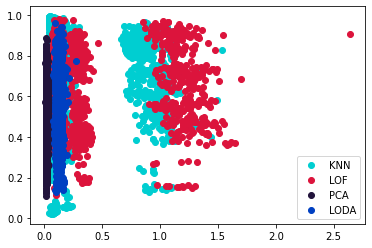

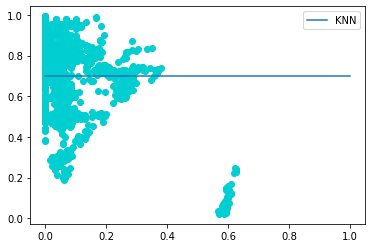

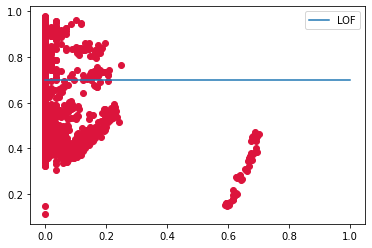

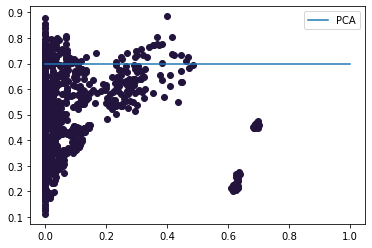

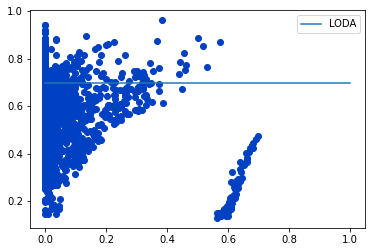

In [115]:
colors1 = '#00CED1' 
colors2 = '#DC143C'
colors = ["#00CED1","#DC143C","#22143C","#0040C2"]
plt.scatter(x=result_knn["time"], y= result_knn["AUC"], c=colors[0])
plt.scatter(x=result_lof["time"], y= result_lof["AUC"], c=colors[1])
plt.scatter(x=result_pca["time"], y= result_pca["AUC"], c=colors[2])
plt.scatter(x=result_loda["time"], y= result_loda["AUC"], c=colors[3])
plt.legend(["KNN","LOF","PCA","LODA"])
plt.show()

plt.scatter(x=result_knn["precision @ rank"], y= result_knn["AUC"], c=colors[0])
plt.plot([0,1],[0.7,0.7])
plt.legend(["KNN"])
plt.show()
plt.scatter(x=result_lof["precision @ rank"], y= result_lof["AUC"], c=colors[1])
plt.plot([0,1],[0.7,0.7])
plt.legend(["LOF"])
plt.show()
plt.scatter(x=result_pca["precision @ rank"], y= result_pca["AUC"], c=colors[2])
plt.plot([0,1],[0.7,0.7])
plt.legend(["PCA"])
plt.show()
plt.scatter(x=result_loda["precision @ rank"], y= result_loda["AUC"], c=colors[3])
plt.plot([0,1],[0.7,0.7])
plt.legend(["LODA"])
plt.show()

从图中可以看出，KNN算法的表现相对要最好，LOF的表现较差。

最后统计具有不同离群率的benmark的AUC，进行比较和分析

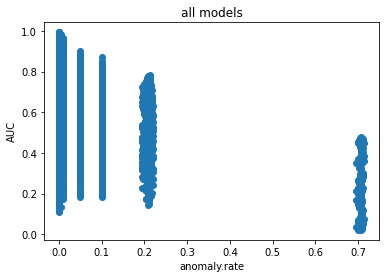

In [120]:
plt.scatter(x=result["anomaly.rate"], y = result["AUC"])
plt.xlabel('anomaly.rate')
plt.ylabel('AUC')
plt.title("all models")
plt.show()

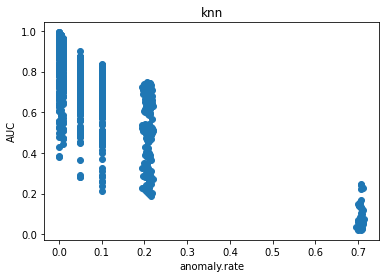

In [123]:
plt.scatter(x=result_knn["anomaly.rate"], y = result_knn["AUC"])
plt.xlabel('anomaly.rate')
plt.ylabel('AUC')
plt.title("knn")
plt.show()

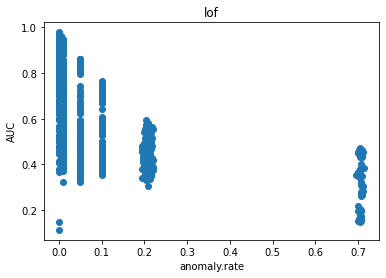

In [124]:
plt.scatter(x=result_lof["anomaly.rate"], y = result_lof["AUC"])
plt.xlabel('anomaly.rate')
plt.ylabel('AUC')
plt.title("lof")
plt.show()

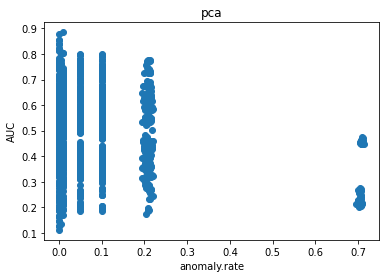

In [125]:
plt.scatter(x=result_pca["anomaly.rate"], y = result_pca["AUC"])
plt.xlabel('anomaly.rate')
plt.ylabel('AUC')
plt.title("pca")
plt.show()

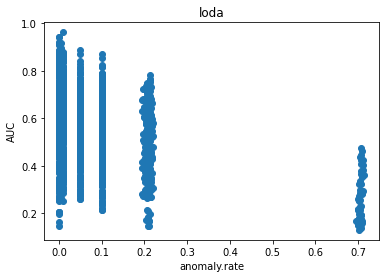

In [126]:
plt.scatter(x=result_loda["anomaly.rate"], y = result_loda["AUC"])
plt.xlabel('anomaly.rate')
plt.ylabel('AUC')
plt.title("loda")
plt.show()

可以看出，离群率越低，检测模型的整体效果和上限也就越高。